<a href="https://colab.research.google.com/github/fabriziobasso/Closet_Index_Tracking/blob/master/File_02_Calories_NN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICTING CALOORIES BURNED

## RMSLE Metric and Competition Context

This notebook is developed for a data science competition focused on predicting **Calories burned** during exercise. The evaluation metric for this competition is the **Root Mean Squared Logarithmic Error (RMSLE)**, which measures the square root of the mean squared difference between the logarithms of predicted and actual values. RMSLE is ideal for datasets with a wide range of target values, as it emphasizes **relative errors**, ensuring balanced performance across small and large calorie values.

The RMSLE formula is:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*AUzyQ1rc6mpQVYfn)

### Why RMSLE?
- **Handles Wide Ranges**: RMSLE penalizes relative errors proportionally, making it robust for calorie values ranging from small (e.g., 10 calories) to large (e.g., 1000 calories).
- **Balanced Evaluation**: Ensures models perform well across the entire spectrum of calorie burn.
- **Competition Goal**: A lower RMSLE score indicates a precise and generalizable model, critical for ranking high on the leaderboard.

---

## Potential Effects of Features on Calorie Burn

The dataset includes the following features to predict calorie burn: **Sex**, **Age**, **Height**, **Weight**, **Duration**, **Heart_Rate**, and **Body_Temp**. Below, we explore how each feature might influence calorie burn:

### 1. Sex
- **Impact**: Differences in metabolic rates and muscle mass between males and females affect calorie burn. Males often have higher muscle mass, leading to greater calorie expenditure for the same exercise.
- **Example**: A male running at the same pace and duration as a female may burn more calories due to higher energy demands.

### 2. Age
- **Impact**: Basal metabolic rate (BMR) decreases with age, reducing calorie burn in older individuals due to lower metabolic rates and muscle mass (sarcopenia).
- **Example**: A 20-year-old may burn more calories than a 50-year-old during identical workouts.

### 3. Height
- **Impact**: Taller individuals have more body mass or muscle, requiring more energy for movement, thus burning more calories. Height’s effect is often linked to weight and exercise intensity.
- **Example**: A taller person may expend more energy covering the same distance.

### 4. Weight
- **Impact**: Heavier individuals burn more calories due to the energy required to move greater body mass. Body composition (fat vs. muscle) also influences calorie burn.
- **Example**: A 90 kg individual burns more calories walking the same distance as a 60 kg individual.

### 5. Duration
- **Impact**: Longer exercise sessions directly increase total calorie expenditure, though intensity and exercise type also matter.
- **Example**: Running for 30 minutes burns more calories than running for 15 minutes.

### 6. Heart_Rate
- **Impact**: Higher heart rates indicate greater exercise intensity and metabolic effort, leading to increased calorie burn. Fitness levels can modulate heart rate responses.
- **Example**: High heart rate during a HIIT workout correlates with higher calorie burn.

### 7. Body_Temp
- **Impact**: Rising body temperature during exercise reflects increased metabolic activity and thermoregulation, potentially increasing calorie burn. Environmental factors (e.g., heat) also play a role.
- **Example**: Exercising in a hot environment may increase calorie expenditure due to thermoregulation.

---

## Transition to Analysis

Understanding the relationships between these features and calorie burn is key to building a predictive model. In this notebook, we will:

1. **Explore Data**: Analyze the distribution of the target variable (**Calories**) and features using visualizations (e.g., histograms, boxplots).
2. **Correlation Analysis**: Identify relationships between features and the target using correlation matrices and polar plots.
3. **Outlier Detection**: Address anomalies that could skew model performance.
4. **Feature Engineering**: Apply techniques like quantile and equal-width binning to enhance model input.
5. **Model Development**: Build and evaluate models to minimize RMSLE, aligning with competition objectives.

### Visualization Strategy
We will use:
- **Histograms** and **boxplots** to examine feature distributions.
- **Correlation matrices** to uncover feature relationships.
- **Polar plots** for creative visualization of feature impacts.
- **Pair plots** to explore pairwise relationships.

By systematically analyzing the data, we aim to develop a robust model that accurately predicts calorie burn and excels in the competition.

---

# 0.0 Setting

## 0.1 Import Libraries:

In [1]:
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.4

In [2]:
%%capture
#!pip install -qq pytorch_tabnet
!pip install optuna
!pip install --upgrade catboost
#!pip install optuna-integration-pytorch-tabnet

#from pytorch_tabnet.tab_model import TabNetRegressor

!pip install --upgrade category-encoders
!pip install optuna-integration
!pip install colorama
#!pip install pyfiglet
#!pip install keras-tuner --upgrade
#!pip install keras-nlp
#!pip install BorutaShap
#!pip install scikit-learn==1.2.2
#!pip install scikit-lego
!pip install skops

In [3]:
import sklearn
import lightgbm, xgboost, catboost
sklearn.__version__, lightgbm.__version__, xgboost.__version__, catboost.__version__

('1.6.1', '4.5.0', '2.1.4', '1.2.8')

In [4]:
# Setup notebook
from pathlib import Path
import ipywidgets as widgets
import pandas as pd
import numpy as np
from pickle import load, dump
import json
import joblib
#from joblib import dump, load
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from termcolor import colored
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from xgboost.callback import EarlyStopping

import lightgbm as lgb
from lightgbm import (LGBMRegressor,
                      LGBMClassifier,
                      early_stopping,
                      record_evaluation,
                      log_evaluation)

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
import datetime
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import backend as K

from keras import ops
from keras import layers
from keras import activations

from keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Reshape
from keras.models import Model
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError

from keras.utils import FeatureSpace, plot_model

# Import libraries for Hypertuning
#import keras_tuner as kt
#from keras_tuner.tuners import RandomSearch, GridSearch, BayesianOptimization

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures,
                                   FunctionTransformer)

# metrics
import sklearn
#import skops.io as sio
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             root_mean_squared_log_error,
                             r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             multilabel_confusion_matrix,
                             accuracy_score,
                             roc_auc_score,
                             auc,
                             roc_curve,
                             log_loss,
                             make_scorer)
# modeling algos
from sklearn.linear_model import (LogisticRegression,
                                  Lasso,
                                  ridge_regression,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV,
                                  ElasticNet,
                                  BayesianRidge,
                                  HuberRegressor,
                                  TweedieRegressor,
                                  QuantileRegressor,
                                  ARDRegression,
                                  TheilSenRegressor,
                                  PoissonRegressor,
                                  GammaRegressor)

from sklearn.ensemble import (AdaBoostRegressor,
                              AdaBoostClassifier,
                              RandomForestRegressor,
                              RandomForestClassifier,
                              VotingRegressor,
                              GradientBoostingRegressor,
                              GradientBoostingClassifier,
                              StackingRegressor,
                              StackingClassifier,
                              HistGradientBoostingClassifier,
                              HistGradientBoostingRegressor,
                              ExtraTreesClassifier)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from category_encoders import TargetEncoder, CatBoostEncoder, LeaveOneOutEncoder, OrdinalEncoder, CountEncoder

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.multioutput import RegressorChain

import itertools
import warnings
from openpyxl import load_workbook

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import statsmodels.api as sm
from pylab import rcParams
import scipy.stats as ss

#from category_encoders.cat_boost import CatBoostEncoder
#from category_encoders.wrapper import PolynomialWrapper
#from category_encoders.count import CountEncoder
#from category_encoders import TargetEncoder

import skops.io as sio

warnings.filterwarnings('ignore')
#import pyfiglet
#plt.style.use('fivethirtyeight')

<Figure size 640x480 with 0 Axes>

**Formatting and Settings:**

In [5]:
sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.5,
         'grid.alpha'           :0.5,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : 'black',
         'axes.titlesize'       : 12,
#         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
# Set Style
mpl.rcParams['figure.dpi'] = 120;

# import font colors
from colorama import Fore, Style, init

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

init(autoreset=True)

<Figure size 960x660 with 0 Axes>

In [6]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
import torch

import warnings
warnings.filterwarnings("ignore")

# Connect to Colab:#
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## 0.2 Functions:

* **Plotting Functiss**

In [7]:
def plot_scatter(df, x="feat1", y="feat2", color_feature=None, cmap='viridis'):
    """
    Generates a scatter plot with points colored based on a third feature.

    Args:
        df: Pandas DataFrame containing the data.
        x: Name of the column to use for the x-axis.
        y: Name of the column to use for the y-axis.
        color_feature: Name of the column to use for coloring the points.
                       If None, points will be a single color.
        cmap: Colormap to use for coloring the points (e.g., 'viridis', 'plasma', 'magma', 'inferno', 'cividis').
              See matplotlib documentation for available colormaps.
    """

    plt.figure(figsize=(8, 5))

    if color_feature is not None:
        # Ensure the color feature exists
        if color_feature not in df.columns:
            raise ValueError(f"Color feature '{color_feature}' not found in DataFrame.")

        # Scatter plot with colors
        scatter = plt.scatter(df[x], df[y], c=df[color_feature], cmap=cmap)

        # Add a colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label(color_feature)  # Label the colorbar

    else:
        # Simple scatter plot (single color)
        plt.scatter(df[x], df[y],color="royalblue",alpha=0.6)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("Scatter Plot")  # Add a title for better visualization
    plt.show()

* **Dataset Management Functions**:

In [8]:
class Config:

    state = 42
    n_splits = 10
    early_stop = 200

    target = 'Calories'
    train = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/test.csv')
    submission = pd.read_csv( "/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv")
    #train_org = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/original.csv")

    original_data = 'N'
    outliers = 'N'
    log_trf = 'Y'
    scaler_trf = 'Y'
    feature_eng = 'N'
    missing = 'Y'
    sqrt_normalization="Y"
    impose_normalization="N"
    trg_enc = "N"
    problem = "Regression"
    metric_goal="LRMSE"
    direction_="minimize"
    log_trans_cols = ["Body_Temp"]
    sqrt_norm_cols = ["Age"]
    impose_norm_cols = []
    trg_enc_feat = []

class Preprocessing():

    def __init__(self):
        self.train = Config.train
        self.test = Config.test
        self.targets = Config.target

        self.prp_data()

    def prp_data(self):

        if Config.original_data == 'Y':
            self.train = pd.concat([self.train, Config.train_org], ignore_index=True).drop_duplicates(ignore_index=True)

        self.train = self.train.drop(['id'], axis=1)
        self.test = self.test.drop(['id'], axis=1)

        self.cat_features = self.train.drop(self.targets, axis=1).select_dtypes(include=['object', 'bool']).columns.tolist()
        self.num_features = self.train.drop(self.targets, axis=1).select_dtypes(exclude=['object', 'bool']).columns.tolist()

        self.train = self.reduce_mem(self.train)
        self.test = self.reduce_mem(self.test)
        return self

    def reduce_mem(self, df):

        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', "uint16", "uint32", "uint64"]

        for col in df.columns:
            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float32)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

        return df

class EDA(Config, Preprocessing):

    def __init__(self):
        super().__init__()

        self.data_info()
        self.heatmap()
        self.dist_plots()
        self.cat_feature_plots()
        if Config.problem == 'Classification':
          self.target_pie()
        else:
          self.target_dist()

    def data_info(self):

        for data, label in zip([self.train, self.test], ['Train', 'Test']):
            table_style = [{'selector': 'th:not(.index_name)',
                            'props': [('background-color', 'slategrey'),
                                      ('color', '#FFFFFF'),
                                      ('font-weight', 'bold'),
                                      ('border', '1px solid #DCDCDC'),
                                      ('text-align', 'center')]
                            },
                            {'selector': 'tbody td',
                             'props': [('border', '1px solid #DCDCDC'),
                                       ('font-weight', 'normal')]
                            }]
            print(Style.BRIGHT+Fore.RED+f'\n{label} head\n')
            display(data.head().style.set_table_styles(table_style))

            print(Style.BRIGHT+Fore.RED+f'\n{label} info\n'+Style.RESET_ALL)
            display(data.info())

            print(Style.BRIGHT+Fore.RED+f'\n{label} describe\n')
            display(data.describe().drop(index='count', columns=self.targets, errors = 'ignore').T
                    .style.set_table_styles(table_style).format('{:.3f}'))

            print(Style.BRIGHT+Fore.RED+f'\n{label} missing values\n'+Style.RESET_ALL)
            display(data.isnull().sum())
        return self

    def heatmap(self):
        print(Style.BRIGHT+Fore.RED+f'\nCorrelation Heatmap\n')
        plt.figure(figsize=(7,7))
        corr = self.train.select_dtypes(exclude='object').corr(method='pearson')
        sns.heatmap(corr, fmt = '0.2f', cmap = 'Blues', annot=True, cbar=False)
        plt.show()

    def dist_plots(self):

        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Numerical\n")
        df = pd.concat([self.train[self.num_features].assign(Source = 'Train'),
                        self.test[self.num_features].assign(Source = 'Test'),],
                        axis=0, ignore_index = True)

        fig, axes = plt.subplots(len(self.num_features), 2 ,figsize = (13, len(self.num_features) * 4),
                                 gridspec_kw = {'hspace': 0.3,
                                                'wspace': 0.2,
                                                'width_ratios': [0.70, 0.30]
                                               }
                                )
        for i,col in enumerate(self.num_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source',
                        palette = ['royalblue', 'tomato'], ax = ax, alpha=0.7, linewidth = 2
                       )
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col}")
            ax.grid('--',alpha=0.7)

            try:
                ax = axes[i,1]
            except:
                ax = axes[1]
            sns.boxplot(data = df, y = col, x=df.Source, width = 0.5,
                        linewidth = 1, fliersize= 1,
                        ax = ax, palette=['royalblue', 'tomato']
                       )
            ax.set_title(f"\n{col}")
            ax.set(xlabel = '', ylabel = '')
            ax.tick_params(axis='both', which='major')
            ax.set_xticklabels(['Train', 'Test'])

        plt.tight_layout()
        plt.show()

    def cat_feature_plots(self):
        print(Style.BRIGHT+Fore.RED+f"\nDistribution analysis - Categorical\n")
        fig, axes = plt.subplots(len(self.cat_features), 2 ,figsize = (18, len(self.cat_features) * 6),
                                 gridspec_kw = {'hspace': 0.5,
                                                'wspace': 0.2,
                                               }
                                )

        for i, col in enumerate(self.cat_features):
            try:
                ax = axes[i,0]
            except:
                ax = axes[i]
            sns.barplot(data=self.train[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='royalblue', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Train")

            try:
                ax = axes[i,1]
            except:
                ax = axes[i+1]
            sns.barplot(data=self.test[col].value_counts().nlargest(10).reset_index(), x=col, y='count', ax=ax, color='tomato', alpha=0.7)
            ax.set(xlabel = '', ylabel = '')
            ax.set_title(f"\n{col} Test")

        plt.tight_layout()
        plt.show()

    def target_pie(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        targets = self.train[self.targets]
        plt.figure(figsize=(6, 6))
        plt.pie(targets.value_counts(), labels=targets.value_counts().index, autopct='%1.2f%%', colors=palette_9)
        plt.show()

    def target_dist(self):
        print(Style.BRIGHT+Fore.RED+f"\nTarget feature distribution\n")
        fig, axes = plt.subplots(1, 1, figsize=(7, 5))
        sns.histplot(self.train[self.targets], kde=True, ax=axes)
        axes.set_title('Distribution of Price')
        axes.set_xlabel(self.targets)
        axes.set_ylabel('Frequency')

# 1.0 EDA

## 1.1 Experiment Area:

In [9]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=15, shuffle=True, random_state=SEED)
    VERSION = '1'

class Data:
    path       = False
    or_path    = ''
    to_drop    = False
    target     = 'Calories'
    drop_duplicates = False

    def __init__(self):
        self.train      = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_03.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_train_03.csv",index_col=0)
        self.test       = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_03.csv",index_col=0).drop(columns=self.to_drop) if self.to_drop else pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/df_test_03.csv",index_col=0)
        self.submission = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)
        self.original   = pd.read_csv(self.or_path) if self.or_path else pd.DataFrame()

        self.train.loc[:,"BMI"] = np.clip(self.train.BMI, a_min=-5.0, a_max=5.0)
        self.test.loc[:,"BMI"] = np.clip(self.test.BMI, a_min=-5.0, a_max=5.0)

    @property
    def X(self):
        return self.train.drop(columns=self.target)
    @property
    def y(self):
        return self.train[[self.target]]
    @property
    def X_test(self):
        return self.test
    @property
    def X_original(self):
        if len(self.original) != 0:
            return self.original.drop(columns=self.target)
        return pd.DataFrame()
    @property
    def y_original(self):
        if len(self.original) != 0:
            return self.original[[self.target]]
        return pd.DataFrame()
    @property
    def cat_features(self):
        return self.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
    @property
    def num_features(self):
        return self.X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def submit(self, sub: np.ndarray, desc: str):
        '''Submit the predictions in the adequate format'''
        self.submission[self.target] = sub
        self.submission.to_csv(f'SUB_{CFG.VERSION}_{desc}.csv', index=False)
        print(colored('Submission has been made.', color='green', attrs=['bold', 'dark']))

    @staticmethod
    def sep_line():
        print(colored(f'{"_____"*14}', color='black'))
        print('')

    @staticmethod
    def head(head_text):
        print(colored(f'{"    "} ➩ {head_text} ', color='green', attrs=['dark']))

    def display_data(self):
        self.head(f'𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: {self.train.shape} | {self.test.shape}')
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝')
        display(self.train.head(5))
        self.head('𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝')
        display(self.test.head(5))
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨')
        display(self.train.info())
        self.head('𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨')
        display(self.test.info())
        self.sep_line()

        self.head('𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.train.describe().T)
        self.head('𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬')
        display(self.test.describe().T)
        self.sep_line()

        def nunique_null(train, test):
            nunique_train, nunique_test = {}, {}
            nulls_train, nulls_test = {}, {}

            for col in test.columns:
                nunique_train[col], nunique_test[col] = train[col].nunique(), test[col].nunique()
                nulls_train[col], nulls_test[col] = train[col].isna().sum(), test[col].isna().sum()

            df = pd.DataFrame([nunique_train, nunique_test,
                               nulls_train, nulls_test],
                              index=['Train nunique', 'Test nunique',
                                     'Train null', 'Test null'])
            return df

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬')
        display(nunique_null(self.train, self.test))
        self.sep_line()

        self.head('𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬')
        display(f'Train duplicated: {self.train.duplicated().sum()}')
        display(f'Test duplicated: {self.test.duplicated().sum()}')

        if self.drop_duplicates==True:
          if self.train.duplicated().sum() > 0:
              self.train = self.train.drop_duplicates()
              print('Train duplicates dropped.')
          if self.test.duplicated().sum() > 0:
              #self.test = self.test.drop_duplicates()
              print('Test duplicates dropped.')
        self.sep_line()

        self.head('𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧')
        cat_cols = [c for c in self.test.columns if self.train[c].nunique() <= 40 or
                    c in self.test.select_dtypes(include=['object', 'category']).columns]

        def compare_unique_categories(train, test, cat_cols):
            unique_train_dic, unique_test_dic = {}, {}

            for c in cat_cols:
                unique_train_c = train[c].unique()
                unique_test_c = test[c].unique()

                count_tr = sum(1 for cat in unique_train_c if cat not in unique_test_c and not pd.isna(cat))
                count_te = sum(1 for cat in unique_test_c if (cat not in unique_train_c and not pd.isna(cat)))

                unique_train_dic[c] = count_tr
                unique_test_dic[c] = count_te

            result_df = pd.DataFrame([unique_train_dic, unique_test_dic],
                                     index=['in train not in test', 'in test not in train'])

            return result_df

        display(compare_unique_categories(self.train, self.test, cat_cols))

data = Data()
data.display_data()

     ➩ 𝐃𝐚𝐭𝐚𝐬𝐞𝐭 𝐬𝐡𝐚𝐩𝐞𝐬 — 𝐓𝐫𝐚𝐢𝐧 | 𝐓𝐞𝐬𝐭: (765000, 16) | (250000, 15) 
______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group,Calories
0,1,1.113015,0.489702,1.266169,0.583480,1.236062,-0.938031,1.183180,-1.090611,-0.952799,1.338352,0,0.848517,0.432900,3,150.0
1,0,-0.909676,-1.081265,-0.888638,-1.109199,-0.430898,-1.184666,-0.923712,-0.418361,0.431582,-1.004625,0,-0.455390,-1.608968,6,34.0
2,0,-1.065268,-0.795635,-1.008350,-1.214992,-0.302671,0.209075,-1.017567,-0.286300,0.610071,-1.047153,0,-0.675342,-0.849602,5,29.0
3,1,1.346402,1.060962,1.146458,1.006650,0.851379,0.026339,1.161541,-0.349679,-0.852901,1.619162,0,0.707173,1.219153,1,140.0
4,0,-0.676289,-1.009858,1.146458,0.689273,0.723151,-1.479569,1.075158,-0.813342,-0.890178,0.535818,0,0.799371,-0.340978,3,146.0


     ➩ 𝐓𝐞𝐬𝐭 𝐡𝐞𝐚𝐝 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
750000,1,0.179465,0.418294,-1.008350,-0.897614,-0.302671,0.978939,-0.995739,0.295543,0.661858,-0.890129,0,-0.658590,-0.307455,4
750001,1,1.968769,1.560816,0.547900,0.583480,0.594924,-0.082149,0.507888,-0.260413,-0.611173,1.078027,0,0.470673,1.781711,2
750002,0,1.035219,0.703924,0.069054,0.689273,0.466696,-0.214836,0.093216,0.624933,-0.294981,0.309886,0,0.254207,2.386314,2
750003,0,-0.209514,-0.152967,0.547900,1.218235,0.723151,0.199218,0.640408,0.708943,-0.533902,0.544812,0,0.691017,0.711718,3
750004,0,-0.131718,-0.581412,0.069054,-0.157067,0.594924,-1.314534,-0.037914,-0.724309,-0.407071,-0.199594,0,0.119383,0.666806,2


______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Duration                      765000 non-null  float64
 4   Heart_Rate                    765000 non-null  float64
 5   Body_Temp                     765000 non-null  float64
 6   BMI                           765000 non-null  float64
 7   Intensity                     765000 non-null  float64
 8   Intensity_v1                  765000 non-null  float64
 9   Heart_Duration                765000 non-null  float64
 10  Weight_Duration_Heart         765000 non-null  float64
 11  Outliers_Duration

None

     ➩ 𝐓𝐞𝐬𝐭 𝐢𝐧𝐟𝐨 
<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           250000 non-null  int64  
 1   Height                        250000 non-null  float64
 2   Weight                        250000 non-null  float64
 3   Duration                      250000 non-null  float64
 4   Heart_Rate                    250000 non-null  float64
 5   Body_Temp                     250000 non-null  float64
 6   BMI                           250000 non-null  float64
 7   Intensity                     250000 non-null  float64
 8   Intensity_v1                  250000 non-null  float64
 9   Heart_Duration                250000 non-null  float64
 10  Weight_Duration_Heart         250000 non-null  float64
 11  Outliers_Duration_Heart_Temp  250000 non-null  int64  
 12  BMI_Age                   

None

______________________________________________________________________

     ➩ 𝐓𝐫𝐚𝐢𝐧 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,765000.0,4.989882e-01,0.499999,0.000000,0.000000,0.000000,1.000000,1.000000
Height,765000.0,5.077641e-16,1.000001,-4.021508,-0.831880,-0.053922,0.801832,3.680276
Weight,765000.0,1.343297e-16,1.000001,-2.795048,-0.867043,-0.081559,0.846740,4.060081
Duration,765000.0,-4.197311e-17,1.000001,-1.726619,-0.888638,-0.050658,0.907035,1.745015
Heart_Rate,765000.0,6.856041e-16,1.000001,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,765000.0,1.793228e-14,1.000001,-3.764820,-0.559126,0.338468,0.851379,1.877201
BMI,765000.0,-1.325152e-04,0.998632,-5.000000,-0.740093,0.011128,0.736294,5.000000
Intensity,765000.0,3.098059e-17,1.000001,-1.563858,-0.875844,-0.105610,0.840522,2.483148
Intensity_v1,765000.0,-1.483010e-15,1.000001,-5.230777,-0.670825,-0.096130,0.539496,8.631268
Heart_Duration,765000.0,1.511371e-15,1.000001,-1.390121,-0.757049,-0.333324,0.443798,4.005130


     ➩ 𝐓𝐞𝐬𝐭 𝐬𝐮𝐦𝐦𝐚𝐫𝐲 𝐬𝐭𝐚𝐭𝐬 


,count,mean,std,min,25%,50%,75%,max
Sex,250000.0,0.498876,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
Height,250000.0,0.002528,0.997501,-3.710325,-0.831880,-0.053922,0.801832,3.446889
Weight,250000.0,0.000396,0.998243,-2.580825,-0.867043,-0.081559,0.846740,3.631636
Duration,250000.0,-0.000926,0.999487,-1.726619,-0.888638,-0.050658,0.907035,1.745015
Heart_Rate,250000.0,-0.000591,0.999756,-3.013464,-0.791822,-0.051275,0.795065,3.439877
Body_Temp,250000.0,0.000066,0.998186,-3.764820,-0.559126,0.338468,0.723151,1.877201
BMI,250000.0,-0.004466,0.998080,-5.000000,-0.740093,0.008131,0.728037,5.000000
Intensity,250000.0,-0.000928,0.999746,-1.563333,-0.876596,-0.107700,0.834455,2.493177
Intensity_v1,250000.0,-0.000195,0.998002,-4.522650,-0.670825,-0.096189,0.539496,7.783418
Heart_Duration,250000.0,-0.000380,0.997461,-1.312222,-0.757049,-0.326515,0.437294,3.835281


______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐚𝐧𝐝 𝐧𝐮𝐥𝐥𝐬 


,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
Train nunique,2,92,92,30,63,75,2201,11378,1268,1102,21630,2,755723,56336,7
Test nunique,2,85,84,30,61,51,1812,9097,1104,973,19010,2,248941,43551,7
Train null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


______________________________________________________________________

     ➩ 𝐃𝐮𝐩𝐥𝐢𝐜𝐚𝐭𝐞𝐬 


'Train duplicated: 2893'

'Test duplicated: 918'

______________________________________________________________________

     ➩ 𝐍𝐮𝐧𝐢𝐪𝐮𝐞 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐞𝐬𝐭/𝐢𝐧 𝐭𝐞𝐬𝐭 𝐧𝐨𝐭 𝐢𝐧 𝐭𝐫𝐚𝐢𝐧 


,Sex,Duration,Outliers_Duration_Heart_Temp,Age_Group
in train not in test,0,0,0,0
in test not in train,0,0,0,0


In [10]:
data.X.shape, data.y.shape, data.X_test.shape

((765000, 15), (765000, 1), (250000, 15))

In [11]:
print(data.cat_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group']


In [12]:
#plot_scatter(pd.concat([data.X,data.y],axis=1), x="BMI", y="Intensity", color_feature="Calories")

In [13]:
data.X.info(),data.X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Sex                           765000 non-null  int64  
 1   Height                        765000 non-null  float64
 2   Weight                        765000 non-null  float64
 3   Duration                      765000 non-null  float64
 4   Heart_Rate                    765000 non-null  float64
 5   Body_Temp                     765000 non-null  float64
 6   BMI                           765000 non-null  float64
 7   Intensity                     765000 non-null  float64
 8   Intensity_v1                  765000 non-null  float64
 9   Heart_Duration                765000 non-null  float64
 10  Weight_Duration_Heart         765000 non-null  float64
 11  Outliers_Duration_Heart_Temp  765000 non-null  int64  
 12  BMI_Age                       765000 non-null  f

(None, None)

In [14]:
data.X_test.shape, data.y.shape

y_test_fic = data.y[:len(data.X_test)].copy()
y_test_fic["Calories"]=np.nan

# 2.0 Neural Networks:


In [15]:
def dataframe_to_dataset(dataframe, target, categorical_features, numerical_features, shuffle=False, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target))

    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

def dataframe_to_dataset_test(dataframe, target_finc, categorical_features, numerical_features, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices(((dataframe[categorical_features].values,  # First input
                                              dataframe[numerical_features].values),
                                              target_finc))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

In [16]:
def plot_training_session(history):
  # Plot training and validation loss scores
  # against the number of epochs.
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Train')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.grid(linestyle='--')
  plt.ylabel('val_loss')
  plt.xlabel('Epoch')
  plt.title('Train-Validation Scores', pad=13)
  plt.legend(loc='upper right');
  plt.show()

def rmsle(y_true, y_pred):
    """
    Root Mean Squared Logarithmic Error (RMSLE)
    """
    # Ensure y_pred is non-negative and add a small constant to avoid log(0) errors
    y_pred = K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) # Corrected: K.maximum

    first_log = K.log(K.maximum(K.cast(y_pred, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum
    second_log = K.log(K.maximum(K.cast(y_true, tf.float32), K.epsilon()) + 1.) # Corrected: K.maximum

    return K.sqrt(K.mean(K.square(first_log - second_log)))

# def rmsle(y_true, y_pred):
#     """
#     Root Mean Squared Logarithm Error
#     Args:
#         y_true ([np.array]): test samples
#         y_pred ([np.array]): predicted samples
#     Returns:
#         [float]: root mean squared logarithm error
#     """
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
#     return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [17]:
class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 0

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=5e-4)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold >= train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

            gc.collect()
            K.clear_session()

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

### **2.1.0 NeuralNetwork: Dense**

In [18]:
data.X.sample(3)

,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
526445,1,0.957423,0.989555,-1.008350,-0.686029,-0.815582,0.712103,-0.987694,0.683439,0.695472,-0.807999,0,-0.732521,0.694678,3
323784,0,0.023874,-0.081559,1.385881,0.477688,1.107835,-0.139503,1.255368,-1.360301,-1.013056,1.129845,0,0.747499,1.507260,2
443738,0,-0.209514,-0.510005,1.625304,2.064575,1.107835,-0.918383,1.933676,0.670868,-0.926571,1.492033,0,1.083775,0.587580,3


In [19]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Duration,1.745015
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Intensity_v1,8.631268
Heart_Duration,4.005130


In [20]:
data.X.min(axis=0)

,0
Sex,0.000000
Height,-4.021508
Weight,-2.795048
Duration,-1.726619
Heart_Rate,-3.013464
Body_Temp,-3.764820
BMI,-5.000000
Intensity,-1.563858
Intensity_v1,-5.230777
Heart_Duration,-1.390121


In [21]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]

print(cat_features,cat_features_card)
print(num_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group'] [2, 2, 8]
['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity', 'Intensity_v1', 'Heart_Duration', 'Weight_Duration_Heart', 'BMI_Age', 'BMR']


In [22]:
np.ceil(np.sqrt(cat_features_card[1]))

np.float64(2.0)

In [23]:
def build_model(units=512,last_layer = 1, activation="relu", do_rate=0.25, reg=0.001):

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(units, activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x = layers.Dense(int(units/last_layer), activation=activation, kernel_regularizer=keras.regularizers.l2(reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(do_rate)(x)
    x_final = layers.Dense(1, activation='linear')(x)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [24]:
mod_test = build_model(units=512)
mod_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None)            │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2)         │          4 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 2)         │          4 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4)         │         32 │ get_item_2[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     10,752 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout_1[0][0] 

 Total params: 542,761 (2.07 MB)

 Trainable params: 539,689 (2.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

#### 2.1.1 Optuna Optimization:

In [25]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Sex                           765000 non-null  int64
 1   Outliers_Duration_Heart_Temp  765000 non-null  int64
 2   Age_Group                     765000 non-null  int64
dtypes: int64(3)
memory usage: 23.3 MB
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Height                 765000 non-null  float64
 1   Weight                 765000 non-null  float64
 2   Duration               765000 non-null  float64
 3   Heart_Rate             765000 non-null  float64
 4   Body_Temp              765000 non-null  float64
 5   BMI                    765000 non-null  float64
 6   Intensity              765000

In [26]:
y_fin.isna().sum()

,0
Calories,0


**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=build_model, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'last_layer': trial.suggest_int('last_layer', 1,2),
              'activation': trial.suggest_categorical('activation', ["relu","silu","mish"]), #, reg=0.001, dropout_rate=0.33) #"relu","selu","gelu","silu"
              'reg': trial.suggest_float('reg', 1e-4, 0.1, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.50, step=0.01)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=build_model, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. {'units': 256,
 'last_layer': 1,
 'activation': 'relu',
 'reg': 0.00039536431216575824,
 'do_rate': 0.32} Score: 0.0631159157056562

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=build_model, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [27]:
param = {'units': 256, 'last_layer': 1, 'activation': 'relu', 'reg': 0.00039536431216575824, 'do_rate': 0.32}
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=build_model, parameters=param)

Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - dense_7_loss: 0.0000e+00 - loss: 2.3003 - msle: 100.4275 - rmsle: 2.1188 - val_dense_7_loss: 0.0000e+00 - val_loss: 0.9588 - val_msle: 87.3727 - val_rmsle: 0.8694 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_7_loss: 0.0000e+00 - loss: 0.8341 - msle: 99.4525 - rmsle: 0.7572 - val_dense_7_loss: 0.0000e+00 - val_loss: 0.5467 - val_msle: 60.2979 - val_rmsle: 0.4937 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_7_loss: 0.0000e+00 - loss: 0.3271 - msle: 84.4576 - rmsle: 0.2780 - val_dense_7_loss: 0.0000e+00 - val_loss: 0.2148 - val_msle: 39.4300 - val_rmsle: 0.1686 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_7_loss: 0.0000e+00 - loss: 0.2520 - msle: 49.6310 - rmsle: 0.2081 - val_dense_7_loss: 0.0000e+00 - val_loss: 0.1587 - val_msle: 10.9038 - val_rmsle: 0.1199 - learning_rate: 5.0000e-04
Epoch 5/151
680/68

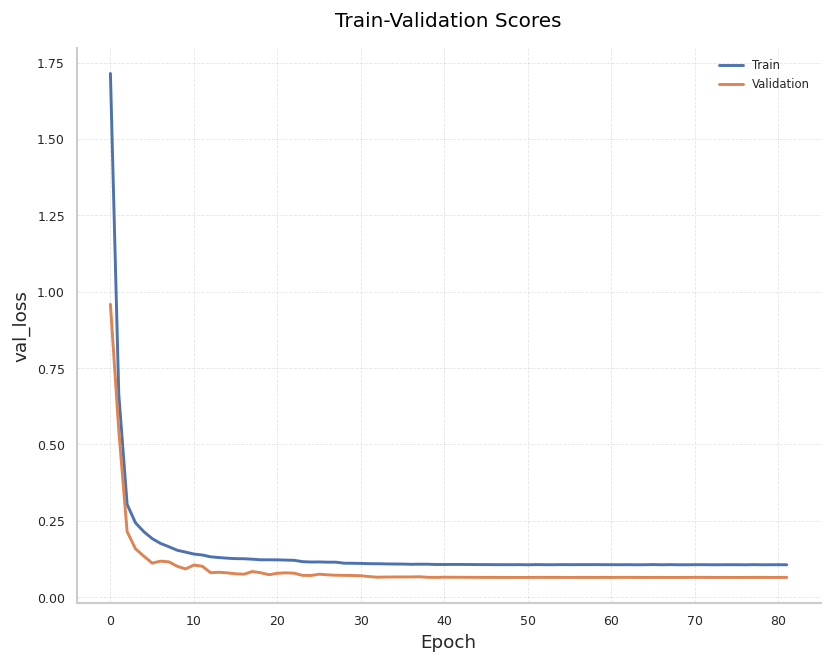

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1 → Training set Score: 1.36029 | Validation set Score: 0.06103
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3770 - msle: 101.0649 - rmsle: 2.1965 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9904 - val_msle: 90.4119 - val_rmsle: 0.9005 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8124 - msle: 99.3215 - rmsle: 0.7348 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.3534 - val_msle: 56.0703 - val_rmsle: 0.2971 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3160 - msle: 86.6981 - rmsle: 0.2633 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.1936 - val_msle: 45.2905 - val_rmsle: 0.1463 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - dense_3_loss: 0.00

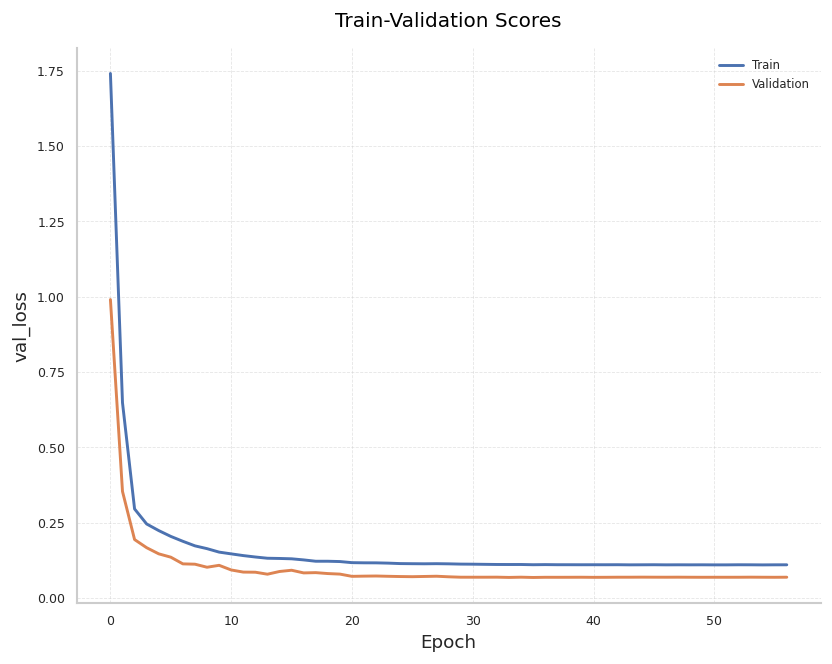

680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2 → Training set Score: 1.35678 | Validation set Score: 0.06373
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3184 - msle: 100.6266 - rmsle: 2.1385 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9820 - val_msle: 90.4756 - val_rmsle: 0.8955 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8344 - msle: 101.0610 - rmsle: 0.7607 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.6743 - val_msle: 69.8193 - val_rmsle: 0.6251 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3405 - msle: 89.8480 - rmsle: 0.2963 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2500 - val_msle: 60.4989 - val_rmsle: 0.2160 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0

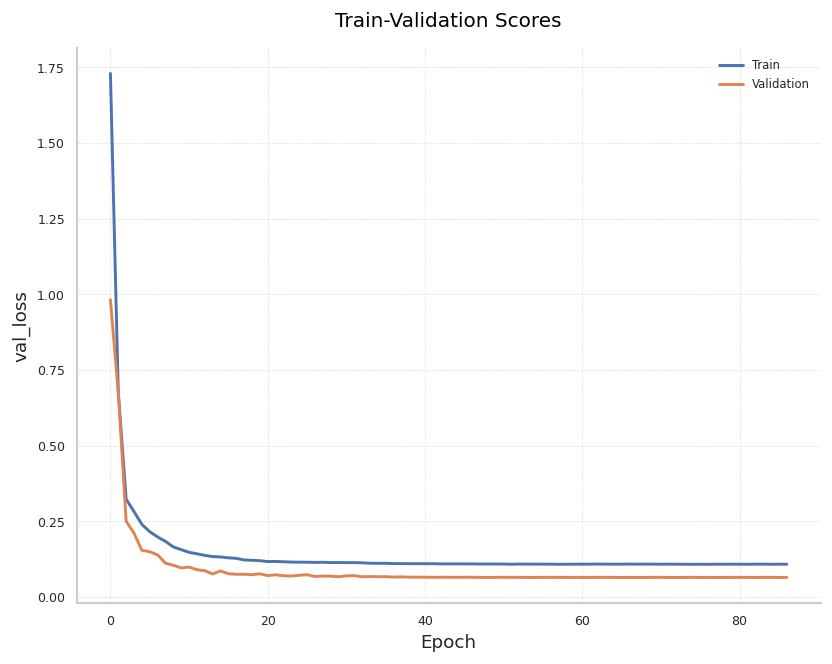

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3 → Training set Score: 1.35865 | Validation set Score: 0.06025
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - dense_3_loss: 0.0000e+00 - loss: 2.2910 - msle: 100.7242 - rmsle: 2.1116 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9879 - val_msle: 93.2800 - val_rmsle: 0.9016 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8338 - msle: 101.5246 - rmsle: 0.7605 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.3685 - val_msle: 87.8723 - val_rmsle: 0.3193 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3339 - msle: 95.7103 - rmsle: 0.2900 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2339 - val_msle: 67.8325 - val_rmsle: 0.2000 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0

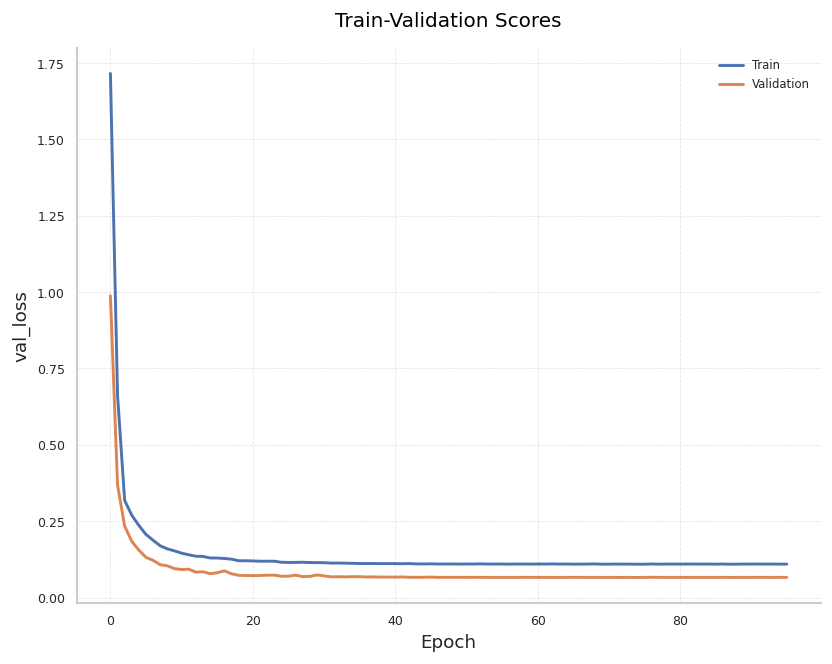

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 4 → Training set Score: 1.35743 | Validation set Score: 0.06248
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3497 - msle: 100.1804 - rmsle: 2.1701 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9827 - val_msle: 90.8211 - val_rmsle: 0.8957 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8128 - msle: 96.2235 - rmsle: 0.7382 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.4158 - val_msle: 74.1960 - val_rmsle: 0.3651 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3247 - msle: 78.7006 - rmsle: 0.2793 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2157 - val_msle: 35.6861 - val_rmsle: 0.1795 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.00

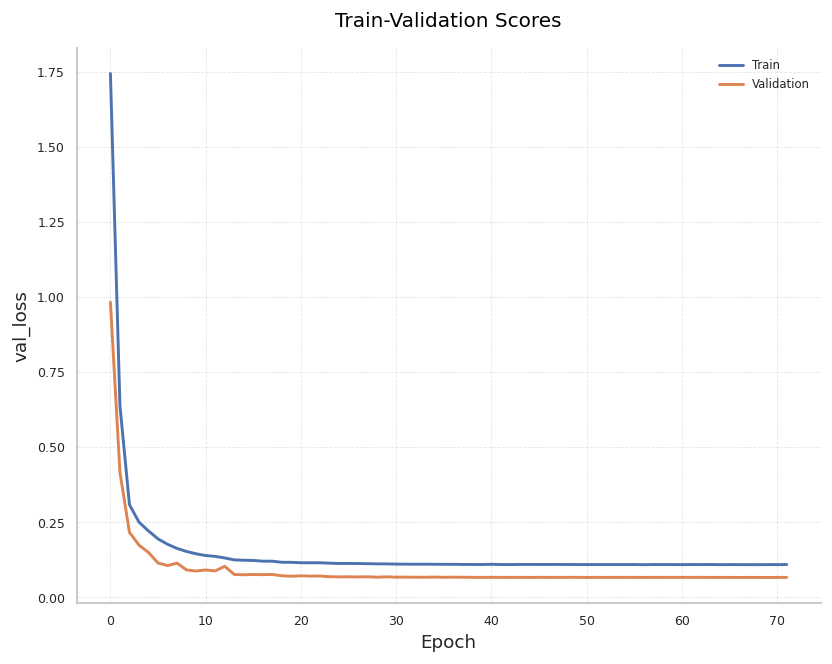

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5 → Training set Score: 1.35819 | Validation set Score: 0.06142
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3211 - msle: 100.3904 - rmsle: 2.1440 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9512 - val_msle: 87.5802 - val_rmsle: 0.8667 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8232 - msle: 100.3433 - rmsle: 0.7515 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9704 - val_msle: 42.2180 - val_rmsle: 0.9226 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3484 - msle: 92.4852 - rmsle: 0.3054 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2521 - val_msle: 140.2582 - val_rmsle: 0.2211 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.

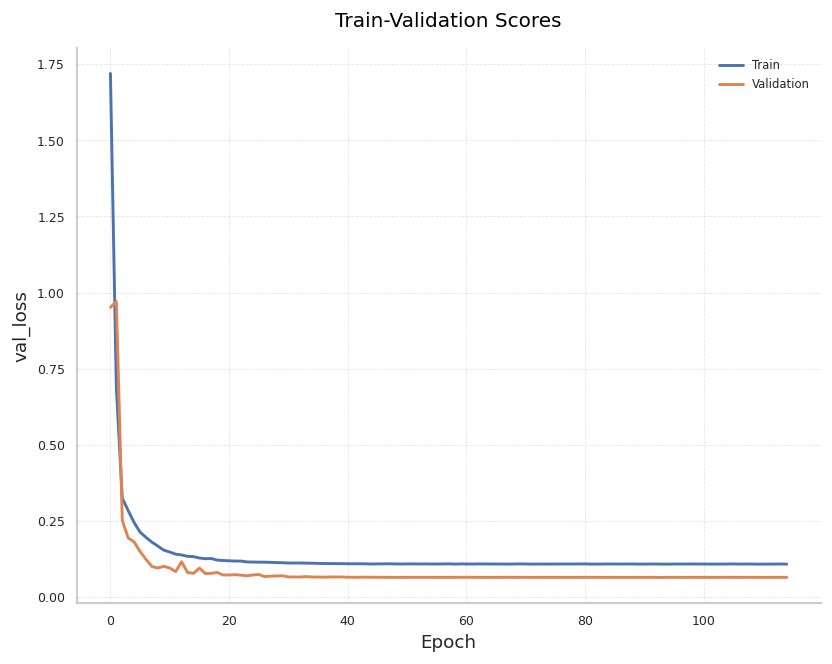

680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 6 → Training set Score: 1.35876 | Validation set Score: 0.06085
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3372 - msle: 100.4986 - rmsle: 2.1546 - val_dense_3_loss: 0.0000e+00 - val_loss: 1.0163 - val_msle: 92.0355 - val_rmsle: 0.9241 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8342 - msle: 96.3670 - rmsle: 0.7553 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.5204 - val_msle: 67.8311 - val_rmsle: 0.4662 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3260 - msle: 74.6927 - rmsle: 0.2734 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.1865 - val_msle: 27.6790 - val_rmsle: 0.1390 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.00

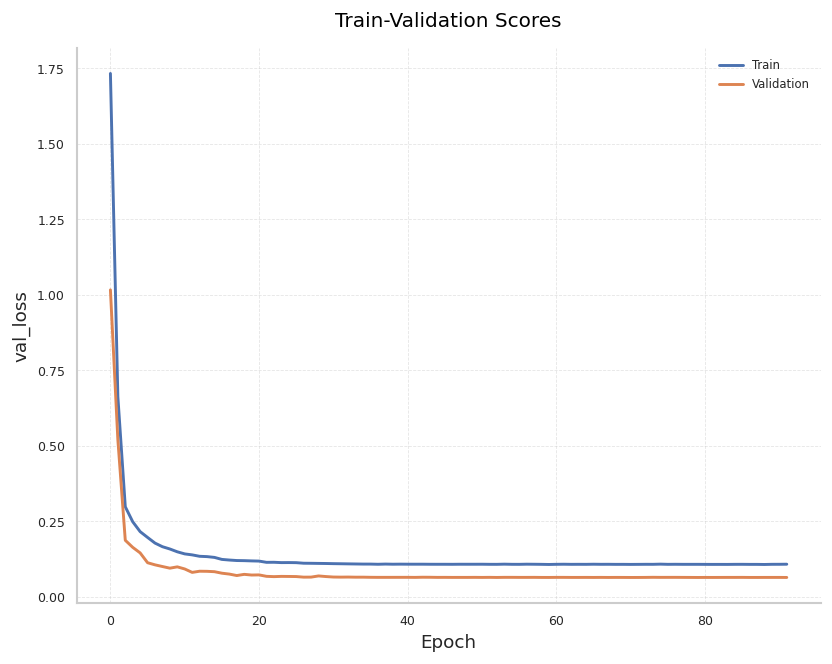

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 7 → Training set Score: 1.35920 | Validation set Score: 0.05866
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3324 - msle: 100.4839 - rmsle: 2.1521 - val_dense_3_loss: 0.0000e+00 - val_loss: 1.0165 - val_msle: 92.6227 - val_rmsle: 0.9293 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8461 - msle: 99.9087 - rmsle: 0.7715 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.6515 - val_msle: 53.7936 - val_rmsle: 0.6002 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3388 - msle: 82.4944 - rmsle: 0.2928 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.1834 - val_msle: 23.5245 - val_rmsle: 0.1493 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.00

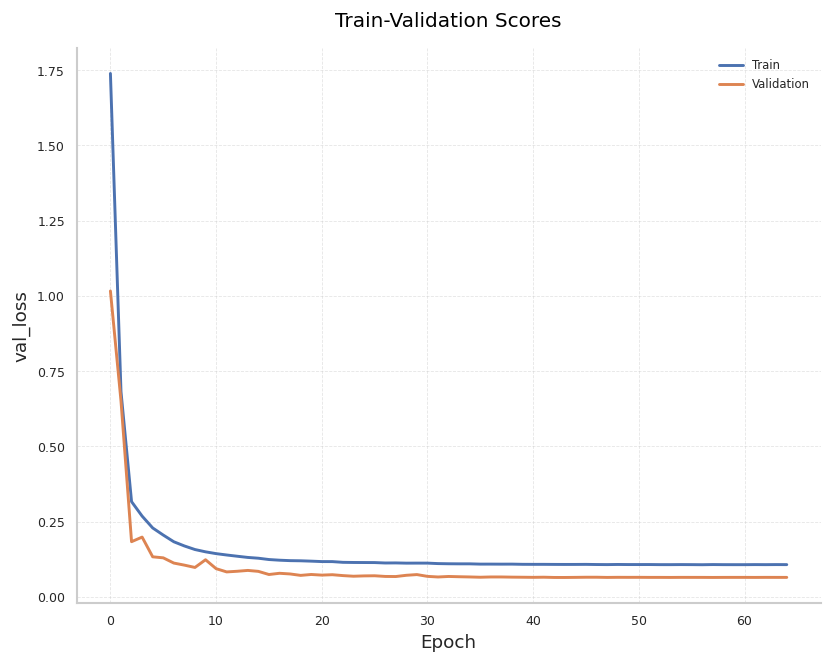

680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 8 → Training set Score: 1.35498 | Validation set Score: 0.06038
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3599 - msle: 101.1118 - rmsle: 2.1793 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9316 - val_msle: 85.8364 - val_rmsle: 0.8435 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.7938 - msle: 99.0733 - rmsle: 0.7181 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.3650 - val_msle: 85.7996 - val_rmsle: 0.3137 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3248 - msle: 84.8263 - rmsle: 0.2782 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2227 - val_msle: 26.3723 - val_rmsle: 0.1836 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.00

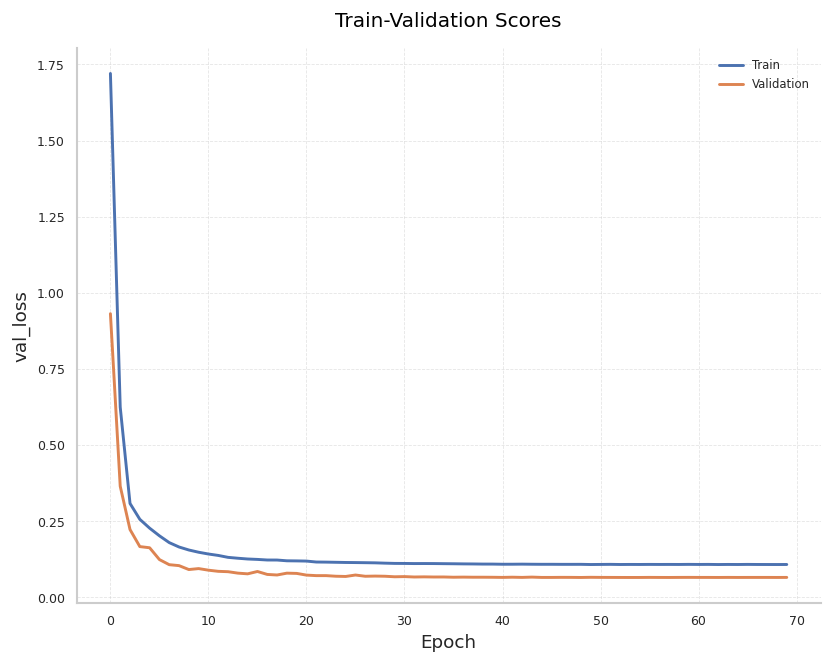

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 9 → Training set Score: 1.35886 | Validation set Score: 0.06126
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3237 - msle: 100.4969 - rmsle: 2.1448 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9399 - val_msle: 86.0323 - val_rmsle: 0.8558 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8294 - msle: 99.5571 - rmsle: 0.7574 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.8080 - val_msle: 76.1212 - val_rmsle: 0.7598 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3410 - msle: 88.2415 - rmsle: 0.2980 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.4778 - val_msle: 351.1219 - val_rmsle: 0.4459 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0

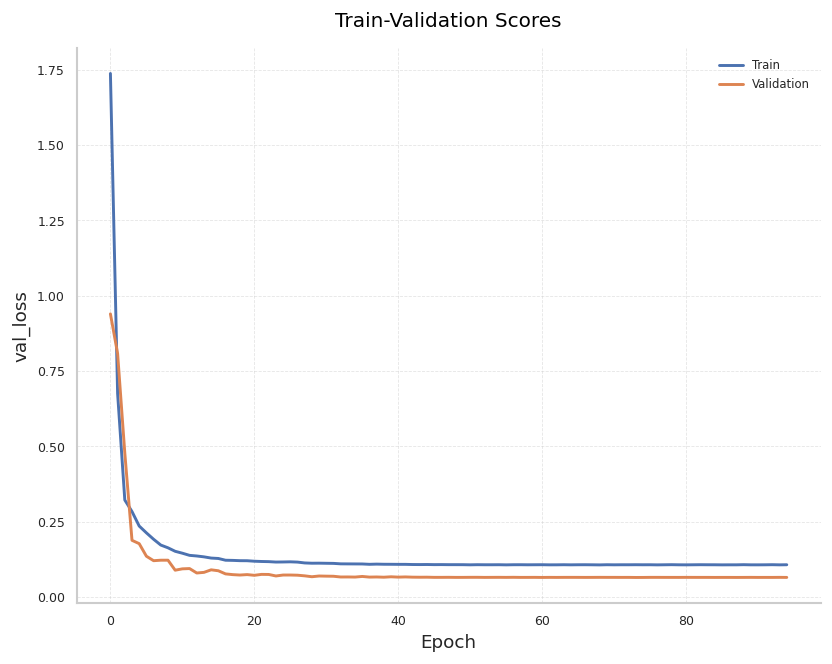

680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 10 → Training set Score: 1.35819 | Validation set Score: 0.06096
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - dense_3_loss: 0.0000e+00 - loss: 2.3245 - msle: 100.4789 - rmsle: 2.1454 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.9730 - val_msle: 90.5040 - val_rmsle: 0.8845 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0000e+00 - loss: 0.8207 - msle: 98.8815 - rmsle: 0.7453 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.4336 - val_msle: 87.5162 - val_rmsle: 0.3833 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_3_loss: 0.0000e+00 - loss: 0.3256 - msle: 86.1434 - rmsle: 0.2802 - val_dense_3_loss: 0.0000e+00 - val_loss: 0.2034 - val_msle: 79.8074 - val_rmsle: 0.1630 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_3_loss: 0.0

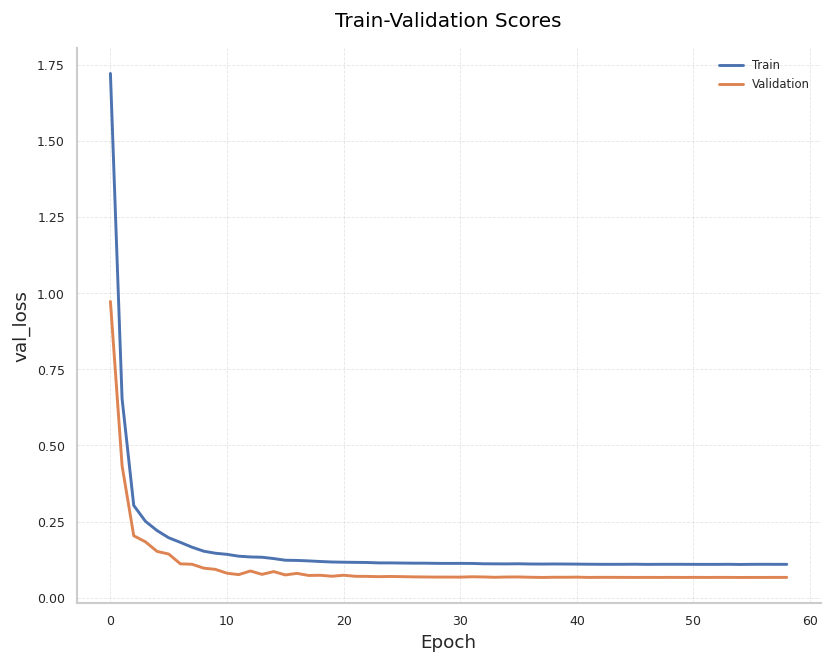

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 11 → Training set Score: 1.35757 | Validation set Score: 0.06262
Overall → Training set Score: 1.35808±0.0013334 | Validation set Score: 0.06124±0.0012920


In [28]:
TM.fit_model(name="NN_exp_01_v1")

#### 2.1.3 Store Results:

In [29]:
train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = ["NN_exp_01_v1"])


sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

sub.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_NN_exp_01_v1.csv")
train_pred.to_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_NN_exp_01_v1.csv")

In [30]:
test_pred.min(), test_pred.max()

(NN_exp_01_v1    1.47834
 dtype: float64,
 NN_exp_01_v1    309.720005
 dtype: float64)

In [31]:
train_pred

,NN_exp_01_v1
0,147.586273
1,35.599743
2,29.276186
3,137.635803
4,146.046570
...,...
764995,43.870289
764996,22.388868
764997,74.584831
764998,9.759145


### **2.2.0 NeuralNetwork: Wide and Deep Model v0**

In [32]:
data.X.sample(3)

,Sex,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Intensity,Intensity_v1,Heart_Duration,Weight_Duration_Heart,Outliers_Duration_Heart_Temp,BMI_Age,BMR,Age_Group
329039,0,-0.598493,-0.867043,0.547900,0.795065,0.466696,-1.180141,0.544818,0.062706,-0.584998,0.189873,0,0.431590,0.293795,2
722862,0,-1.143063,-1.366896,0.787323,1.218235,0.594924,-1.652647,0.861178,0.387029,-0.661129,0.217312,0,0.508480,-0.351212,2
23862,1,1.346402,1.703631,1.505592,1.006650,0.979607,1.640750,1.504058,-0.716564,-0.997418,2.354950,0,0.934391,1.639237,2


In [33]:
data.X.max(axis=0)

,0
Sex,1.000000
Height,3.680276
Weight,4.060081
Duration,1.745015
Heart_Rate,3.439877
Body_Temp,1.877201
BMI,5.000000
Intensity,2.483148
Intensity_v1,8.631268
Heart_Duration,4.005130


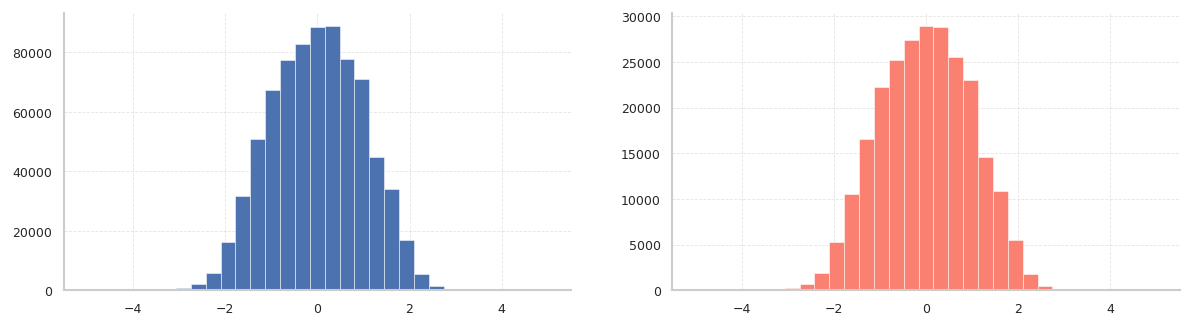

In [34]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.BMI, bins=31)
ax[1].hist(data.X_test.BMI, bins=31, color="salmon")

plt.show()

In [35]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

['Sex', 'Outliers_Duration_Heart_Temp', 'Age_Group'] [2, 2, 8]
['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Intensity', 'Intensity_v1', 'Heart_Duration', 'Weight_Duration_Heart', 'BMI_Age', 'BMR']


In [36]:
def wide_deep(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    wide = layers.BatchNormalization()(x)
    deep = x

    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [37]:
mod_test = wide_deep(units=512, activation="celu")
mod_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None)            │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None)            │          0 │ input_layer[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 2)         │          4 │ get_item[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 2)         │          4 │ get_item_1[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 4)         │         32 │ get_item_2[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_deep_0        │ (None, 512)       │     10,752 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_deep_0           │ (None, 512)       │      2,048 │ dense_deep_0[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ celu (Celu)         │ (None, 512)       │          0 │ bn_deep_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ do_deep_0 (Dropout) │ (None, 512)       │          0 │ celu[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_deep_1        │ (None, 512)       │    262,656 │ do_deep_0[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_deep_1           │ (None, 512)       │      2,048 │ dense_deep_1[0][… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 542,861 (2.07 MB)

 Trainable params: 539,749 (2.06 MB)

 Non-trainable params: 3,112 (12.16 KB)

In [38]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.2.1 Optuna Optimization:

In [39]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 3 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Sex                           765000 non-null  int64
 1   Outliers_Duration_Heart_Temp  765000 non-null  int64
 2   Age_Group                     765000 non-null  int64
dtypes: int64(3)
memory usage: 23.3 MB
<class 'pandas.core.frame.DataFrame'>
Index: 765000 entries, 0 to 1014999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Height                 765000 non-null  float64
 1   Weight                 765000 non-null  float64
 2   Duration               765000 non-null  float64
 3   Heart_Rate             765000 non-null  float64
 4   Body_Temp              765000 non-null  float64
 5   BMI                    765000 non-null  float64
 6   Intensity              765000

In [40]:
y_fin.isna().sum()

,0
Calories,0


**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'activation': "silu", #trial.suggest_categorical('activation', ["relu","prelu","silu","mish"]), #, reg=0.001, dropout_rate=0.33)
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.40, step=0.01),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,4)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dw.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=37,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

        gc.collect()

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

(Sex                             0
 Height                          0
 Weight                          0
 Duration                        0
 Heart_Rate                      0
 Body_Temp                       0
 BMI                             0
 Intensity                       0
 Intensity_v1                    0
 Heart_Duration                  0
 Weight_Duration_Heart           0
 Outliers_Duration_Heart_Temp    0
 BMI_Age                         0
 BMR                             0
 Age_Group                       0
 dtype: int64,
 Calories    1.0
 dtype: float64)

  1. Trial 32 finished with value: 0.06224817614285113 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.000103427172893175, 'do_rate': 0.40056000512858025, 'hidden_layers': 2}

  2. Trial 18 finished with value: 0.06211038027842043 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.0001004170129215336, 'do_rate': 0.41356627172269655, 'hidden_layers': 3} Best

  3.  Trial 23 finished with value: 0.06239891244956206 and parameters: {'units': 512, 'last_layer': 2, 'activation': 'silu', 'reg': 0.00010001356287977584, 'do_rate': 0.4642367345915417, 'hidden_layers': 2}.

In [ ]:
nn0_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep, n_trials=32, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn0_study.best_params

In [ ]:
cat_params

{'units': 256,
 'reg': 0.00011385972470561927,
 'do_rate': 0.32999999999999996,
 'hidden_layers': 3}

  1. Trial 21 finished with value: 0.06031049367720441 and parameters: {'units': 256, 'reg': 0.00011385972470561927, 'do_rate': 0.33, 'hidden_layers': 3}

In [ ]:
optuna.visualization.plot_optimization_history(nn0_study)

In [ ]:
optuna.visualization.plot_param_importances(nn0_study)

In [ ]:
optuna.visualization.plot_contour(nn0_study, params=["units", "hidden_layers"])

#### 2.2.2 Train Model:

In [41]:
param =  {'units': 256, 'reg': 0.00011385972470561927, 'do_rate': 0.33, 'hidden_layers': 3}

In [42]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep, parameters=param)

Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - dense_1_loss: 0.0000e+00 - loss: 2.3122 - msle: 98.1091 - rmsle: 2.2547 - val_dense_1_loss: 0.0000e+00 - val_loss: 0.7065 - val_msle: 64.9961 - val_rmsle: 0.6694 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_1_loss: 0.0000e+00 - loss: 0.4797 - msle: 49.3597 - rmsle: 0.4486 - val_dense_1_loss: 0.0000e+00 - val_loss: 0.1434 - val_msle: 14.8444 - val_rmsle: 0.1254 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_1_loss: 0.0000e+00 - loss: 0.1311 - msle: 9.7239 - rmsle: 0.1153 - val_dense_1_loss: 0.0000e+00 - val_loss: 0.0977 - val_msle: 7.9907 - val_rmsle: 0.0865 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_1_loss: 0.0000e+00 - loss: 0.1157 - msle: 8.9228 - rmsle: 0.1054 - val_dense_1_loss: 0.0000e+00 - val_loss: 0.0785 - val_msle: 5.3309 - val_rmsle: 0.0699 - learning_rate: 5.0000e-04
Epoch 5/151
680/680 ━━

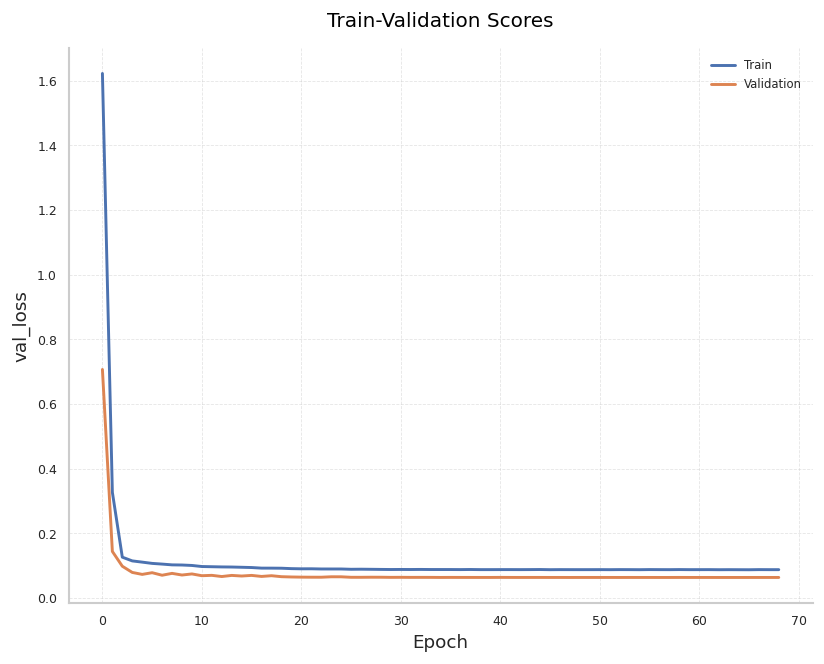

680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Fold 1 → Training set Score: 1.36047 | Validation set Score: 0.06078
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - dense_loss: 0.0000e+00 - loss: 2.2664 - msle: 97.9214 - rmsle: 2.2095 - val_dense_loss: 0.0000e+00 - val_loss: 0.7196 - val_msle: 66.2448 - val_rmsle: 0.6845 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.4994 - msle: 51.3622 - rmsle: 0.4702 - val_dense_loss: 0.0000e+00 - val_loss: 0.1286 - val_msle: 14.8014 - val_rmsle: 0.1118 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1328 - msle: 10.2318 - rmsle: 0.1179 - val_dense_loss: 0.0000e+00 - val_loss: 0.0965 - val_msle: 6.6046 - val_rmsle: 0.0857 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss:

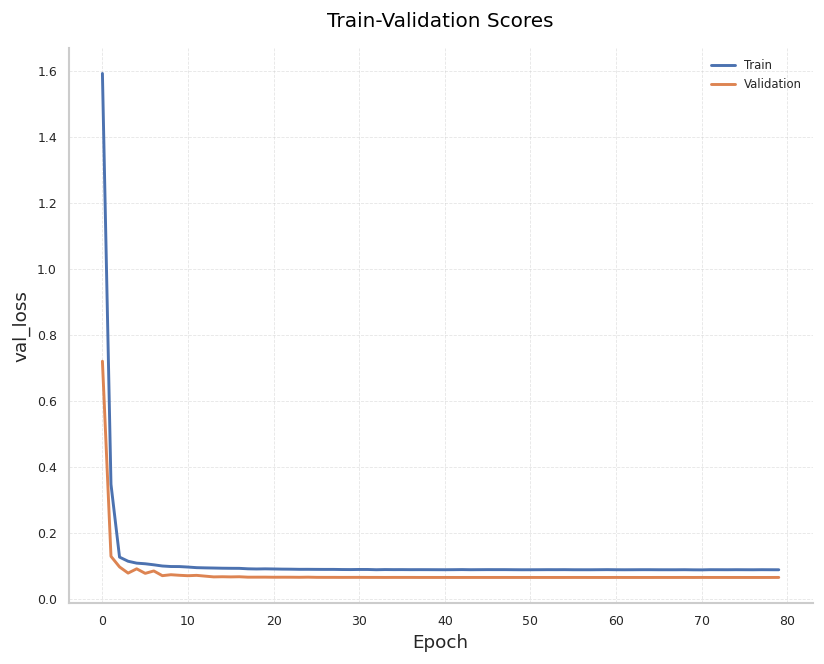

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 2 → Training set Score: 1.35974 | Validation set Score: 0.06234
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.2511 - msle: 97.8307 - rmsle: 2.1941 - val_dense_loss: 0.0000e+00 - val_loss: 0.7167 - val_msle: 66.0818 - val_rmsle: 0.6811 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.5034 - msle: 51.4974 - rmsle: 0.4737 - val_dense_loss: 0.0000e+00 - val_loss: 0.1462 - val_msle: 14.8741 - val_rmsle: 0.1289 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1332 - msle: 9.8963 - rmsle: 0.1178 - val_dense_loss: 0.0000e+00 - val_loss: 0.0856 - val_msle: 5.0735 - val_rmsle: 0.0743 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0

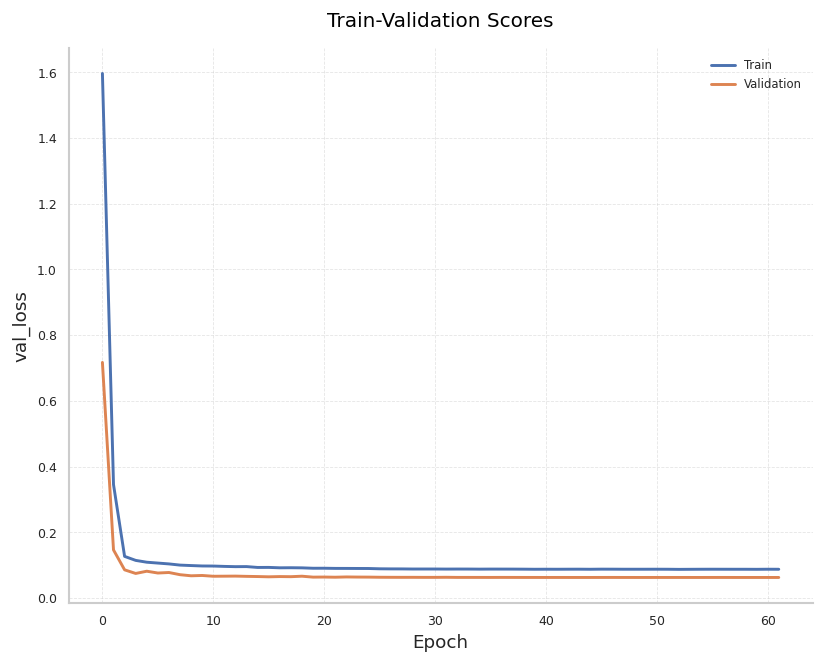

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 3 → Training set Score: 1.36357 | Validation set Score: 0.06000
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.2216 - msle: 97.7933 - rmsle: 2.1645 - val_dense_loss: 0.0000e+00 - val_loss: 0.7388 - val_msle: 67.7107 - val_rmsle: 0.7027 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.5223 - msle: 53.0989 - rmsle: 0.4922 - val_dense_loss: 0.0000e+00 - val_loss: 0.1186 - val_msle: 12.8378 - val_rmsle: 0.1010 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1383 - msle: 11.0237 - rmsle: 0.1225 - val_dense_loss: 0.0000e+00 - val_loss: 0.0905 - val_msle: 6.0939 - val_rmsle: 0.0788 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss:

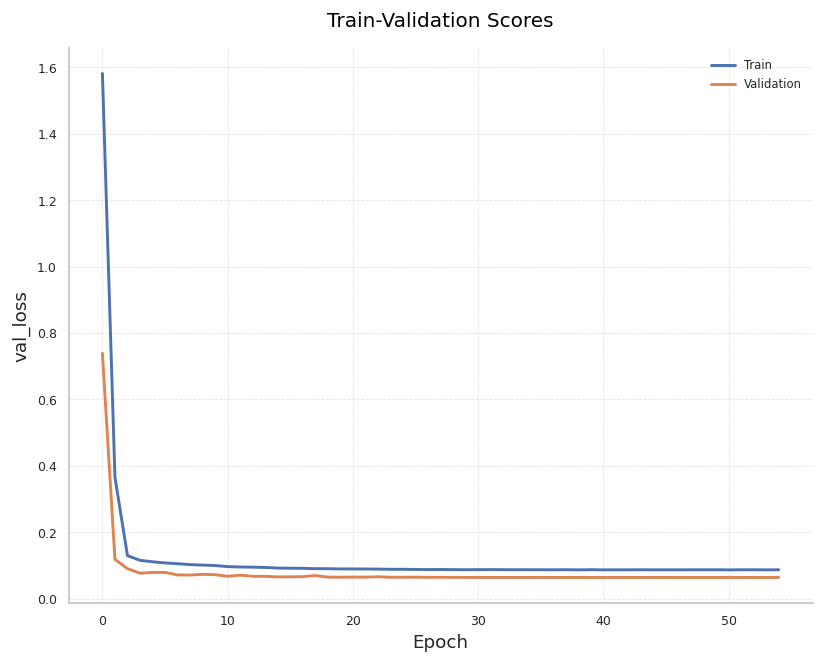

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4 → Training set Score: 1.36070 | Validation set Score: 0.06160
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - dense_loss: 0.0000e+00 - loss: 2.2785 - msle: 98.0312 - rmsle: 2.2213 - val_dense_loss: 0.0000e+00 - val_loss: 0.7229 - val_msle: 66.4139 - val_rmsle: 0.6867 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.5067 - msle: 51.6633 - rmsle: 0.4764 - val_dense_loss: 0.0000e+00 - val_loss: 0.1387 - val_msle: 15.3101 - val_rmsle: 0.1210 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1357 - msle: 10.4474 - rmsle: 0.1200 - val_dense_loss: 0.0000e+00 - val_loss: 0.0923 - val_msle: 6.7615 - val_rmsle: 0.0810 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 

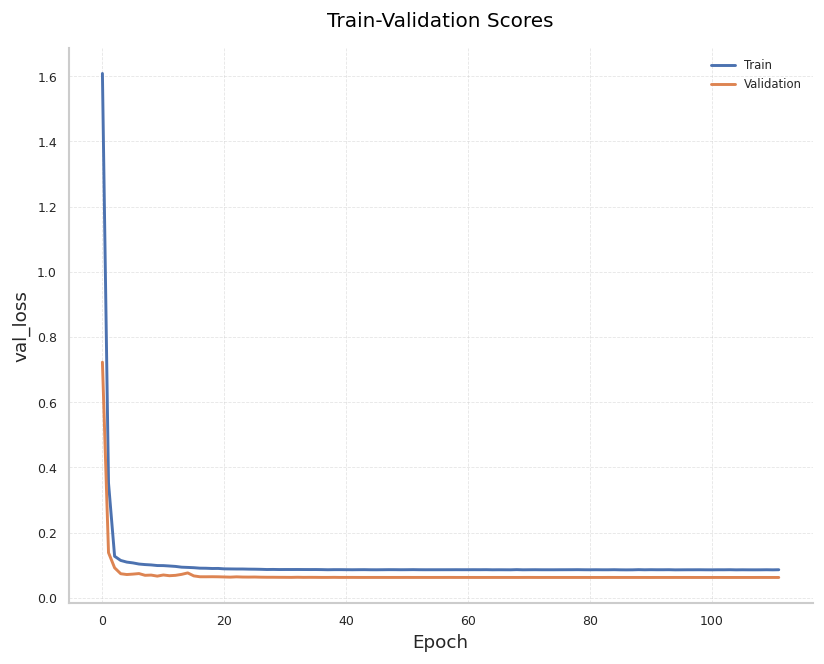

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 5 → Training set Score: 1.36056 | Validation set Score: 0.06061
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - dense_loss: 0.0000e+00 - loss: 2.2863 - msle: 98.1774 - rmsle: 2.2293 - val_dense_loss: 0.0000e+00 - val_loss: 0.7569 - val_msle: 68.3046 - val_rmsle: 0.7209 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.5334 - msle: 53.5881 - rmsle: 0.5034 - val_dense_loss: 0.0000e+00 - val_loss: 0.1288 - val_msle: 13.6769 - val_rmsle: 0.1113 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1355 - msle: 10.2631 - rmsle: 0.1199 - val_dense_loss: 0.0000e+00 - val_loss: 0.0808 - val_msle: 4.8617 - val_rmsle: 0.0695 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 

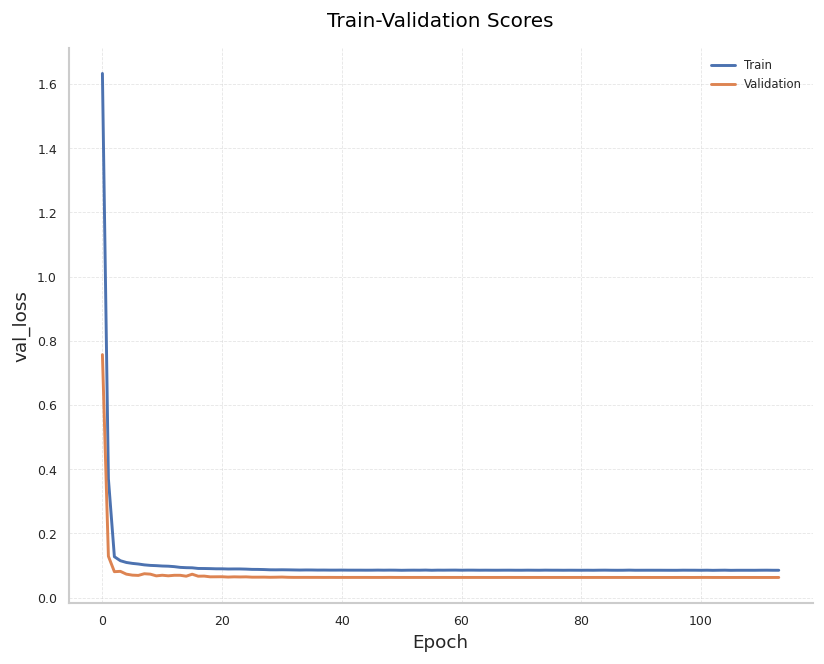

680/680 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 6 → Training set Score: 1.36104 | Validation set Score: 0.06049
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.4069 - msle: 99.2197 - rmsle: 2.3495 - val_dense_loss: 0.0000e+00 - val_loss: 0.6417 - val_msle: 62.0165 - val_rmsle: 0.6059 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.4397 - msle: 47.2321 - rmsle: 0.4101 - val_dense_loss: 0.0000e+00 - val_loss: 0.1094 - val_msle: 9.1491 - val_rmsle: 0.0924 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1263 - msle: 9.6887 - rmsle: 0.1113 - val_dense_loss: 0.0000e+00 - val_loss: 0.0847 - val_msle: 5.8039 - val_rmsle: 0.0742 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0

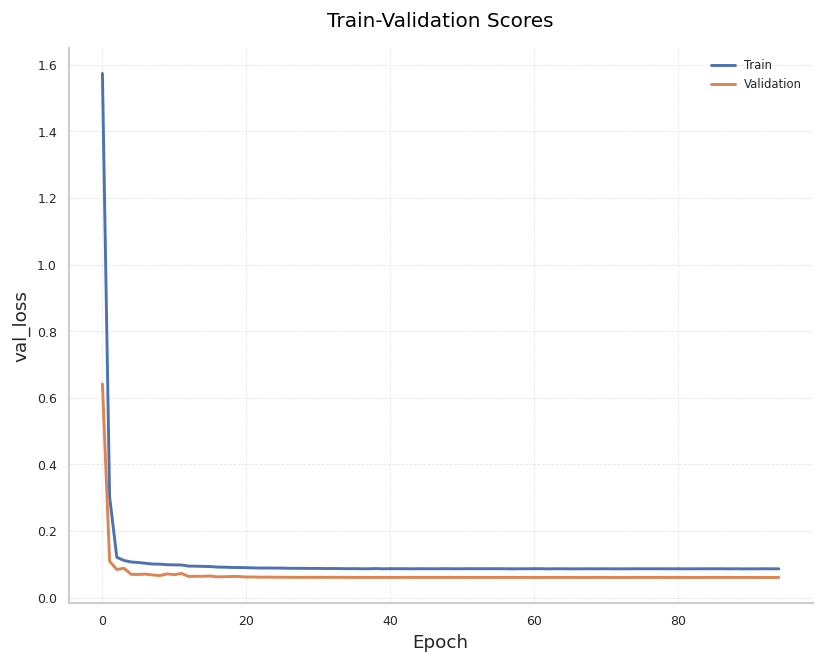

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 7 → Training set Score: 1.36048 | Validation set Score: 0.05836
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.2188 - msle: 97.6608 - rmsle: 2.1618 - val_dense_loss: 0.0000e+00 - val_loss: 0.7453 - val_msle: 67.7624 - val_rmsle: 0.7091 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_loss: 0.0000e+00 - loss: 0.5359 - msle: 53.9033 - rmsle: 0.5056 - val_dense_loss: 0.0000e+00 - val_loss: 0.1265 - val_msle: 13.7056 - val_rmsle: 0.1084 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1422 - msle: 11.7413 - rmsle: 0.1260 - val_dense_loss: 0.0000e+00 - val_loss: 0.0836 - val_msle: 5.9124 - val_rmsle: 0.0713 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 

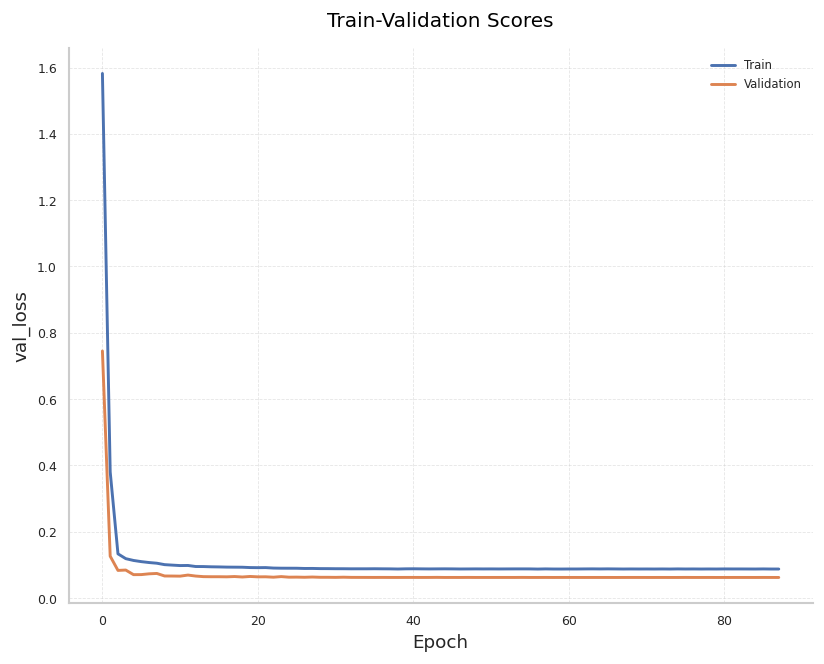

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 8 → Training set Score: 1.36044 | Validation set Score: 0.05963
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.3176 - msle: 98.2066 - rmsle: 2.2604 - val_dense_loss: 0.0000e+00 - val_loss: 0.6944 - val_msle: 64.8746 - val_rmsle: 0.6573 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.4881 - msle: 49.9840 - rmsle: 0.4570 - val_dense_loss: 0.0000e+00 - val_loss: 0.1337 - val_msle: 13.3266 - val_rmsle: 0.1150 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - dense_loss: 0.0000e+00 - loss: 0.1352 - msle: 10.2069 - rmsle: 0.1186 - val_dense_loss: 0.0000e+00 - val_loss: 0.0836 - val_msle: 6.2780 - val_rmsle: 0.0714 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 

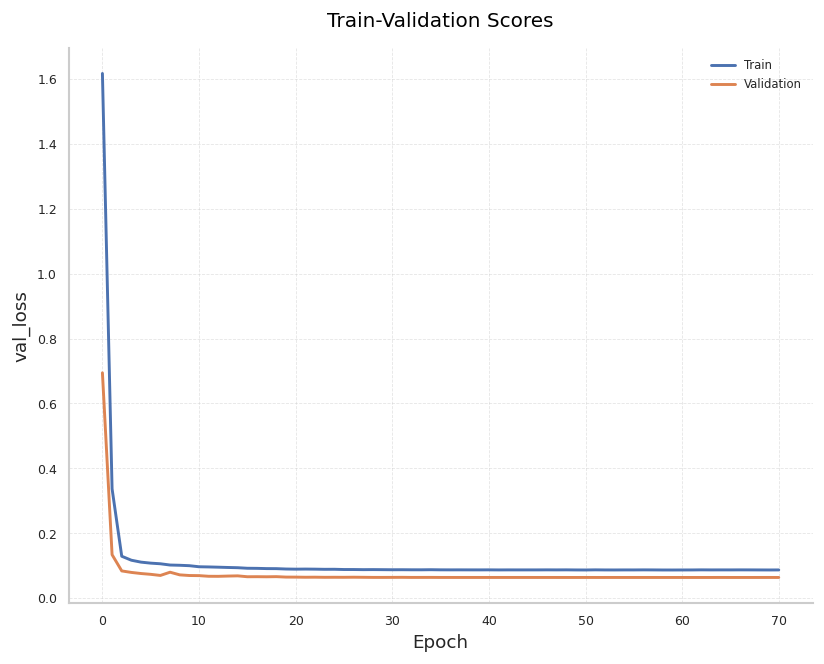

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 9 → Training set Score: 1.36110 | Validation set Score: 0.06101
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - dense_loss: 0.0000e+00 - loss: 2.3405 - msle: 98.4916 - rmsle: 2.2830 - val_dense_loss: 0.0000e+00 - val_loss: 0.7010 - val_msle: 64.4953 - val_rmsle: 0.6635 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.4872 - msle: 50.2737 - rmsle: 0.4556 - val_dense_loss: 0.0000e+00 - val_loss: 0.1157 - val_msle: 11.0138 - val_rmsle: 0.0959 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1417 - msle: 11.0002 - rmsle: 0.1237 - val_dense_loss: 0.0000e+00 - val_loss: 0.0854 - val_msle: 5.4453 - val_rmsle: 0.0715 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 

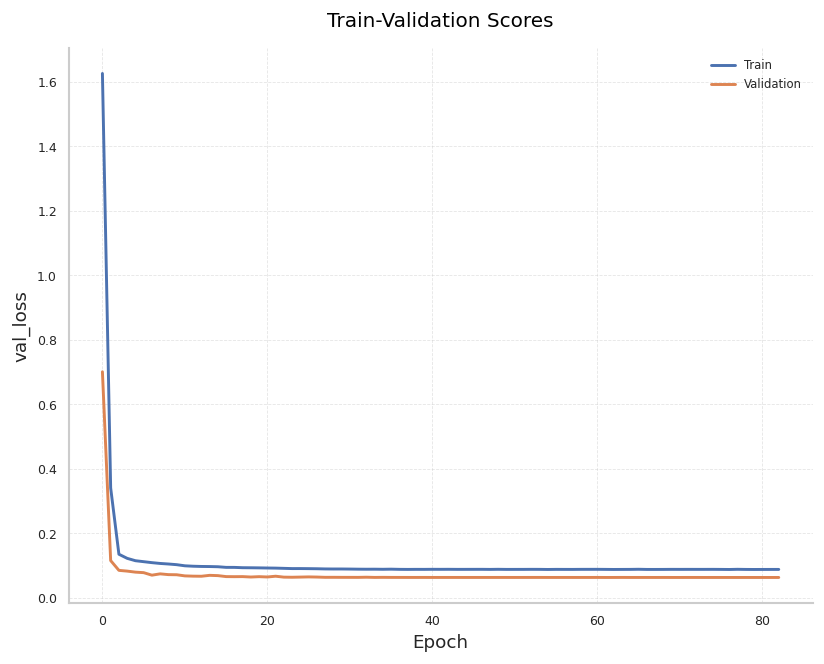

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 10 → Training set Score: 1.36159 | Validation set Score: 0.06084
Epoch 1/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - dense_loss: 0.0000e+00 - loss: 2.2986 - msle: 98.4037 - rmsle: 2.2415 - val_dense_loss: 0.0000e+00 - val_loss: 0.6991 - val_msle: 64.8010 - val_rmsle: 0.6629 - learning_rate: 5.0000e-04
Epoch 2/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.4919 - msle: 50.7289 - rmsle: 0.4617 - val_dense_loss: 0.0000e+00 - val_loss: 0.1225 - val_msle: 13.5931 - val_rmsle: 0.1042 - learning_rate: 5.0000e-04
Epoch 3/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss: 0.1375 - msle: 10.4992 - rmsle: 0.1209 - val_dense_loss: 0.0000e+00 - val_loss: 0.0802 - val_msle: 4.3615 - val_rmsle: 0.0676 - learning_rate: 5.0000e-04
Epoch 4/151
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dense_loss: 0.0000e+00 - loss:

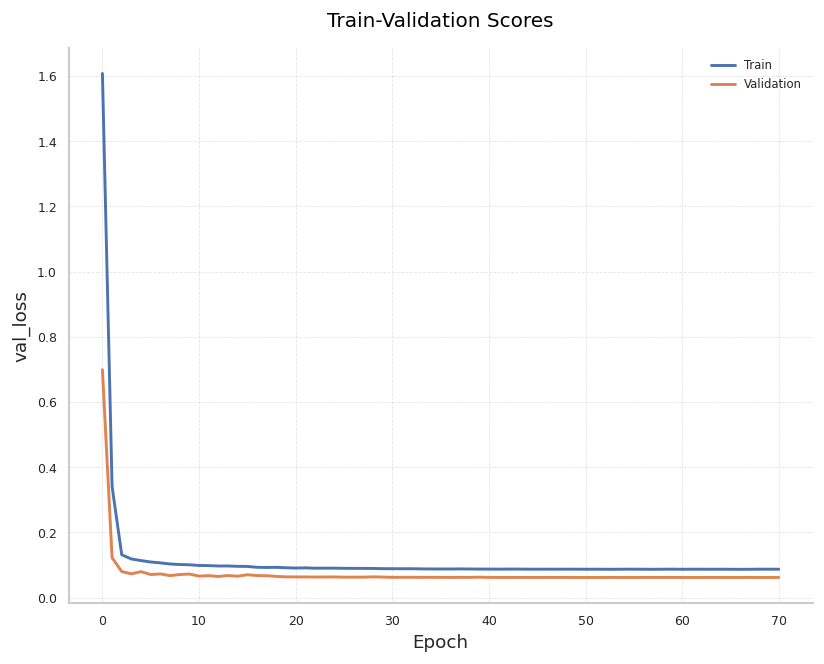

680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 11 → Training set Score: 1.36001 | Validation set Score: 0.05940
Overall → Training set Score: 1.36088±0.0009772 | Validation set Score: 0.06046±0.0010369


In [43]:
TM.fit_model(name="NN_widedeep_01_v1")

#### 2.2.3 Store Results:

In [58]:
# train_pred = TM.OOF_train
# train_pred

In [52]:
name_experiment = "NN_widedeep_01_v3"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred.values, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [53]:
test_pred.min(), test_pred.max()

(NN_widedeep_01_v1    1.0
 dtype: float64,
 NN_widedeep_01_v1    309.057743
 dtype: float64)

In [54]:
test_pred.head()

,NN_widedeep_01_v1
0,27.433917
1,108.045536
2,87.176998
3,125.929819
4,75.608258


In [55]:
sub.head()

,Calories
id,
750000,27.433917
750001,108.045536
750002,87.176998
750003,125.929819
750004,75.608258


In [56]:
train_pred.head()

,NN_widedeep_01_v3
0,146.325775
1,35.991413
2,29.003366
3,139.192993
4,145.229919


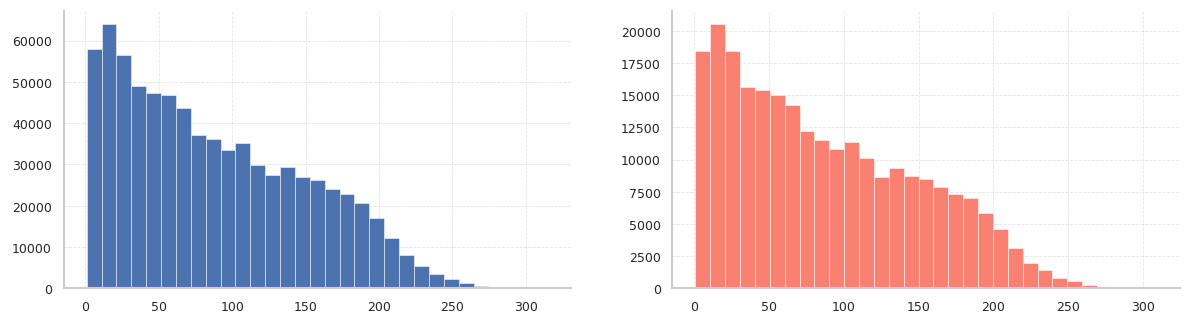

In [57]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [59]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: Wide and Deep Model v1**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Age_Group, bins=31)
ax[1].hist(data.X_test.Age_Group, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep_cross(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3, num_cross_layers=2):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    deep = x
    wide = x  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])

    # Deep Branch:
    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep_cross(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep_cross, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'num_cross_layers': trial.suggest_int('num_cross_layers', 1, 3),
              'activation': trial.suggest_categorical('activation', ["relu","prelu","silu"]),
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.25, 0.45),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,3)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=37,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6, monitor="val_rmsle", mode="min"),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

NameError: name 'wide_deep_cross' is not defined

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 1 finished with value: 0.061372210432322494 and parameters: {'units': 512, 'num_cross_layers': 1, 'activation': 'relu', 'reg': 0.0007600657726479304, 'do_rate': 0.4197061058874465, 'hidden_layers': 2}.

  2. Trial 6 finished with value: 0.061261933879490194 and parameters: {'units': 256, 'num_cross_layers': 1, 'activation': 'silu', 'reg': 0.0001002990796038959, 'do_rate': 0.39009941717483704, 'hidden_layers': 2}. Best

  3.  Trial

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep_cross, n_trials=37, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 512, 'num_cross_layers': 3, 'activation': 'prelu', 'reg': 0.0001360583533261253, 'do_rate': 0.3763917280440354,  'hidden_layers': 2}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep_cross, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeepcross_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_widedeepcross_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: TabTransformer Model v0**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
from functools import partial

class CFG:
    SEED    = 333
    CV      = KFold(n_splits=11, shuffle=True, random_state=SEED)
    VERSION = '1'

class TrainModels:
    def __init__(self, X, y, X_test, test_finc_target, X_original, y_original, model_, parameters):
        self.model     = model_
        self.parameters = parameters
        self.X          = X
        self.y          = y
        self.test_finc_target = test_finc_target
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
        self.numerical_features = X.select_dtypes(exclude=['category', 'bool', 'category','int']).columns.to_list()

    def fit_model(self, name="Base_model"):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/layers_3_staked_models')

        train_start = 7

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]


            train_ds = dataframe_to_dataset(x_train, y_train, self.categorical_features, self.numerical_features, shuffle=True, batch_size=1024)
            val_ds = dataframe_to_dataset(x_val, y_val, self.categorical_features, self.numerical_features, shuffle=False, batch_size=1024)
            test_ds = dataframe_to_dataset_test(self.X_test, self.test_finc_target, self.categorical_features, self.numerical_features, batch_size=1024)

            model = self.model(**self.parameters)

            optimizer = keras.optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=optimizer,
                          loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                          metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

            checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                                                                        filepath=checkpoint_filepath,
                                                                        save_weights_only=True,
                                                                        monitor='val_rmsle',
                                                                        mode='min',
                                                                        save_best_only=True
                                                                        )
            if fold > train_start:
              # Fit the model
              history = model.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=151,
                                  batch_size=1024,
                                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                                            keras.callbacks.EarlyStopping(patience=21, restore_best_weights=True, monitor="val_rmsle",
                                                                            start_from_epoch=3, mode="min"),
                                              model_checkpoint_callback])

              model.load_weights(checkpoint_filepath)
              model.save(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras")
              plot_training_session(history)

            else:
              model = tf.keras.models.load_model(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/keras_models/{name}_{fold}.keras",
                                                custom_objects={'rmsle': rmsle})

            model.evaluate(val_ds, verbose=0)

            # Make predictions
            y_pred_train = model.predict(train_ds)
            y_pred_val   = model.predict(val_ds)
            y_pred_test  = model.predict(test_ds)

            # Correct Ranges:

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            # Store Results
            oof_train[val_idx] = y_pred_val.reshape(-1)
            oof_test   += (y_pred_test/CFG.CV.get_n_splits()).reshape(-1)

            train_score = root_mean_squared_log_error(y_train, y_pred_train)
            val_score   = root_mean_squared_log_error(y_val, y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Body_Temp, bins=31)
ax[1].hist(data.X_test.Body_Temp, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [ ]:
[4]*2+[2]

In [ ]:
def tabtransformer(do_rate=0.25, num_cross_layers=2, embedding_dims=4, num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2]):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    x_input_nums = layers.Input(shape=(len(num_features),))



    # Embedding Cat Features
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], embedding_dims) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        embs.append(x)

    encoded_categorical_features = ops.stack(embs, axis=1)


    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=do_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=do_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(layers.LayerNormalization, epsilon=1e-6),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(x_input_nums)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features], name="concatenate_att_output")

    # Compute MLP hidden_units.
    mlp_hidden_units = [factor * features.shape[-1] for factor in mlp_hidden_units_factors]
    # Create final MLP.
    features = create_mlp(
                          hidden_units=mlp_hidden_units,
                          dropout_rate=do_rate,
                          activation=keras.activations.silu,
                          normalization_layer=layers.BatchNormalization,
                          name="MLP_post_attention",
                         )(features)

    # WIDE Branch of the NN
    embs_cross = []

    for j in embs:
        embs_cross.append(layers.Flatten()(j))

#    embs_cross = layers.Flatten()(embs)
    x1 = layers.Concatenate(axis=-1)(embs_cross+[x_input_nums])

    wide = x1  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x1.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x1, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])


    merged = layers.concatenate([wide, features])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = tabtransformer()
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

  1. Trial 3 finished with value: 0.06128411016249404 and parameters: {'num_cross_layers': 3, 'do_rate': 0.34650500123999023, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 4, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 2}

  2. rial 22 finished with value: 0.06113841138214773 and parameters: {'num_cross_layers': 3, 'do_rate': 0.3631276829855239, 'embedding_dims': 4, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 2, 'mlp_hidden_units_factors_1': 3, 'mlp_hidden_units_factors_2': 1}.

  3. Trial 7 finished with value: 0.060843740984653075 and parameters: {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors_0': 3, 'mlp_hidden_units_factors_1': 2, 'mlp_hidden_units_factors_2': 1}

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=tabtransformer, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

#(num_transformer_blocks=3, num_heads=8, mlp_hidden_units_factors=[4]*2+[2])

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'num_cross_layers': 3, #trial.suggest_int('num_cross_layers', 1, 3),
              'do_rate': trial.suggest_float('do_rate', 0.30, 0.40, step=0.01),
              'embedding_dims': 4, #trial.suggest_categorical('embedding_dims', [4, 8]),
              'num_transformer_blocks': trial.suggest_categorical('num_transformer_blocks', [3, 4]),
              'num_heads': trial.suggest_categorical('num_heads', [4, 8, 12]),
              'mlp_hidden_units_factors_0' : trial.suggest_categorical('mlp_hidden_units_factors_0', [2, 3]),
              'mlp_hidden_units_factors_1' : trial.suggest_categorical('mlp_hidden_units_factors_1', [2, 3]),
              'mlp_hidden_units_factors_2' : trial.suggest_categorical('mlp_hidden_units_factors_2', [1, 2]),
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(do_rate=params["do_rate"], num_cross_layers=params["num_cross_layers"], embedding_dims=params["embedding_dims"], num_transformer_blocks=params["num_transformer_blocks"],
                            num_heads=params["num_heads"], mlp_hidden_units_factors=[params["mlp_hidden_units_factors_0"]]*params["mlp_hidden_units_factors_1"]+[params["mlp_hidden_units_factors_2"]])

        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=tabtransformer, n_trials=27, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param =  {'do_rate': 0.32, 'num_transformer_blocks': 3, 'num_heads': 12, 'mlp_hidden_units_factors': [3,3,1]}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=tabtransformer, parameters=param)

In [ ]:
TM.fit_model(name="NN_TabTransformer_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_TabTransformer_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

### **2.3.0 NeuralNetwork: Wide and Deep Model v2**

This version of the model includes a Cross Layers within the Wide Branch of the NN.

In [ ]:
data.X.sample(3)

In [ ]:
data.X.max(axis=0)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(data.X.Age_Group, bins=31)
ax[1].hist(data.X_test.Age_Group, bins=31, color="salmon")

plt.show()

In [ ]:
cat_features = data.cat_features
num_features = data.num_features

cat_features_card = [2,2,8]
cat_features_out = [2, 2, 4]


print(cat_features,cat_features_card)
print(num_features)

In [ ]:
def wide_deep_cross(units=512, activation="relu", do_rate=0.25, reg=0.001, hidden_layers=3, num_cross_layers=2):
    '''
    In this model embedding is performed for the data feeding into both the Deep and and wide layers:
    '''

    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(cat_features_card[j], cat_features_out[j]) #np.ceil(np.sqrt(cat_features_card[1]))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)

    x_input_nums = layers.Input(shape=(len(num_features),))

    x = layers.Concatenate(axis=-1)(embs+[x_input_nums])

    deep = x
    wide = x  # Both Branches start with the concatenated features

    # Wide Branch with Cross Layers:
    for _ in range(num_cross_layers):
        xl = layers.Dense(units=x.shape[-1],  # Output dimension same as input
                         kernel_initializer='glorot_uniform',
                         bias_initializer='zeros',
                         activation=None)(wide)  # Linear activation
        # Cross Layer Calculation:
        cross = layers.Multiply()([x, xl])  # Element-wise multiplication
        # Concatenate instead of Add:
        wide = layers.Concatenate(axis=-1)([wide, cross])

    # Deep Branch:
    for lay in range(hidden_layers):
        deep = layers.Dense(units,kernel_regularizer=keras.regularizers.l2(reg), name=f"dense_deep_{lay}")(deep)
        deep = layers.BatchNormalization(name=f"bn_deep_{lay}")(deep)
        if activation == "relu":
            deep = layers.ReLU(name=f"relu_deep_{lay}")(deep)
        elif activation == "prelu":
            deep = layers.PReLU(name=f"prelu_deep_{lay}")(deep)
        elif activation == "gelu ":
            deep = activations.gelu(deep)
        elif activation == "silu":
            deep = activations.silu(deep)
        elif activation == "mish":
            deep = layers.Lambda(lambda x: keras.activations.mish(x), name=f"mish_deep_{lay}")(deep)
        elif activation == "celu":
            deep = activations.celu(deep)

        deep = layers.Dropout(do_rate, name=f"do_deep_{lay}")(deep)

    merged = layers.concatenate([wide, deep])

    x_final = layers.Dense(1, activation='linear')(merged)

    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x_final)
    return model

In [ ]:
mod_test = wide_deep_cross(units=512, activation="celu")
mod_test.summary()

In [ ]:
#keras.utils.plot_model(mod_test, show_shapes=True, rankdir="LR")

#### 2.3.1 Optuna Optimization:

In [ ]:
X_fin = data.X
X_test_fin = data.X_test

X_train_cat = data.X[cat_features]
X_train_num = data.X[num_features]

X_test_cat = data.X_test[cat_features]
X_test_num = data.X_test[num_features]

X_train_cat.info()
X_train_num.info()

y_fin = data.y

In [ ]:
y_fin.isna().sum()

**OPTIMIZATION SECTION**

In [ ]:
def objective_nn(trial, X, y, n_splits, n_repeats, model=wide_deep_cross, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold"):

    model_class = model

    categorical_features = cat_features.copy()

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'units': trial.suggest_categorical('units', [128,256,512,1024]),
              'num_cross_layers': trial.suggest_int('num_cross_layers', 1, 3),
              'activation': trial.suggest_categorical('activation', ["relu","prelu","silu"]),
              'reg': trial.suggest_float('reg', 1e-4, 0.01, log=True),
              'do_rate': trial.suggest_float('do_rate', 0.25, 0.45),
              'hidden_layers': trial.suggest_int('hidden_layers', 1,3)
              }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmsle_scores = []

    keras.backend.clear_session()

    iteration_n=0

    for idx_train, idx_valid in kf.split(X, y):
        print(f"Running Fold: {iteration_n}")
        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy()#.reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy()#.reshape(-1, 1)

        X_train_cat = X_train[cat_features]
        X_train_num = X_train[num_features]

        X_valid_cat = X_valid[cat_features]
        X_valid_num = X_valid[num_features]

        # Create the model
        keras.utils.set_random_seed(rs)
        model = model_class(**params)

        optimizer = keras.optimizers.Adam(learning_rate=5e-4)
        model.compile(optimizer=optimizer,
                      loss=[rmsle, keras.losses.MeanSquaredLogarithmicError(name="msle")],
                      metrics=[rmsle, keras.metrics.RootMeanSquaredError(name="msle")])

        checkpoint_filepath = '/tmp/ckpt/checkpoint_dwc.weights.h5'
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_rmsle',
            mode='min',
            save_best_only=True)

        # Fit the model
        model.fit([X_train_cat,X_train_num], y_train,
                  validation_data=([X_valid_cat, X_valid_num], y_valid),
                  epochs=31,
                  batch_size=1024,
                  callbacks=[keras.callbacks.ReduceLROnPlateau(patience=3, factor = 0.5, min_lr=1e-6),
                            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_rmsle",
                                                            start_from_epoch=3, mode="min"),
                             model_checkpoint_callback])

        model.load_weights(checkpoint_filepath)

        # Make predictions on the validation set
        y_pred = model.predict([X_valid_cat, X_valid_num], batch_size=1024)
        y_pred = np.maximum(y_pred, 1.0)
        y_pred = np.minimum(y_pred, 315.0)

        print("Pred Min: {}".format(y_pred.min()))
        print("Pred Max: {}".format(y_pred.max()))

        # Calculate the RMSE for the current fold
        rmsle_score = root_mean_squared_log_error(y_valid, y_pred)
        print(f"Fold {iteration_n} RMSLE: {rmsle_score}")

        rmsle_scores.append(rmsle_score)
        iteration_n+=1

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmsle_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(lambda trial: objective_nn(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
X_fin.isna().sum(), y_fin.min()

  1. Trial 1 finished with value: 0.061372210432322494 and parameters: {'units': 512, 'num_cross_layers': 1, 'activation': 'relu', 'reg': 0.0007600657726479304, 'do_rate': 0.4197061058874465, 'hidden_layers': 2}.

  2. Trial 6 finished with value: 0.061261933879490194 and parameters: {'units': 256, 'num_cross_layers': 1, 'activation': 'silu', 'reg': 0.0001002990796038959, 'do_rate': 0.39009941717483704, 'hidden_layers': 2}. Best

  3.  Trial

In [ ]:
nn3_study = tune_hyperparameters(X_fin, y_fin, model_class=wide_deep_cross, n_trials=37, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)

cat_params = nn3_study.best_params

In [ ]:
cat_params

#### 2.1.2 Train Model:

In [ ]:
param = {'units': 512, 'num_cross_layers': 3, 'activation': 'prelu', 'reg': 0.0001360583533261253, 'do_rate': 0.3763917280440354,  'hidden_layers': 2}

In [ ]:
TM = TrainModels(X=data.X, y=data.y, X_test=data.X_test, test_finc_target=y_test_fic, X_original=None, y_original=None, model_=wide_deep_cross, parameters=param)

In [ ]:
TM.fit_model(name="NN_widedeepcross_00")

#### 2.1.3 Store Results:

In [ ]:
name_experiment = "NN_widedeepcross_00"

train_pred = TM.OOF_train
test_pred = TM.OOF_test
train_pred = pd.DataFrame(data = train_pred, columns = [f"{name_experiment}"])

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

sub["Calories"] =  test_pred.values

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

# **3.0 TREE BASED MODELS**

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
# class_weights = dict(enumerate(class_weights))

# sample_pos_weight = class_weights[1]/class_weights[0]
# sample_pos_weight

In [ ]:
class TrainModels:
    def __init__(self, X, y, X_test, X_original, y_original, models):
        self.models     = models
        self.X          = X
        self.y          = y
        self.X_original = X_original
        self.y_original = y_original
        self.X_test     = X_test
        self._OOF_train = pd.DataFrame()
        self._OOF_test  = pd.DataFrame()
        self.categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

    @staticmethod
    def convert_cat(df_):
        '''
        A function to convert dtypes to categorical if the catboost with all categorical
        features is called
        '''
        df = df_.copy()
        for c in df.columns.to_list():
            df[c] = df[c].astype(str).astype('category')
        return df


    def fit_model(self, name, model_, train_flag):
        oof_train = np.zeros(self.X.shape[0])
        oof_test  = np.zeros(self.X_test.shape[0])
        scores_train = []
        scores_val   = []

        CB_CAT_FLAG = True if 'CB_CAT' in name.upper() else False

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Models/S5E5/Catboost')

        for fold, (train_idx, val_idx) in enumerate(CFG.CV.split(self.X, self.y)):
            x_train, y_train = self.X.iloc[train_idx], self.y.iloc[train_idx]
            x_val,   y_val   = self.X.iloc[val_idx],   self.y.iloc[val_idx]

            # Adds the original data to training set only
            if self.X_original is not None:
                x_train = pd.concat([x_train, self.X_original], axis=0)
                y_train = pd.concat([y_train, self.y_original], axis=0)

            # -- Create a special block to convert all features to categorical
            if CB_CAT_FLAG:
                x_train = self.convert_cat(x_train)
                x_val   = self.convert_cat(x_val)

            model = clone(model_)

            if 'CB' in name.upper():
              if train_flag==True:
                model.fit(x_train,y_train,eval_set=[(x_val,y_val)], early_stopping_rounds=101)
                model.save_model(f"{name}_{fold}.bin")
              else:
                print("Load Model")
                model = CatBoostRegressor()
                model.load_model(f"{name}_{fold}.bin")

            elif 'LGBMR' in name.upper():
              early_stop = early_stopping(stopping_rounds=101)
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)], callbacks=[early_stop],categorical_feature=self.categorical_features)
                model.booster_.save_model(f'{name}_{fold}.txt')
              else:
                print("Load Model")
                model = lgb.Booster(model_file=f'{name}_{fold}.txt')

            elif 'LGBMP' in name.upper():
              # Fit the model
              if train_flag==True:
                model.fit(x_train, y_train)
                joblib.dump(model, f'{name}_{fold}.pkl')
              else:
                print("Load Model")
                model = joblib.load(f'{name}_{fold}.pkl')

            elif 'XGBR' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train, eval_set=[(x_val, y_val)],verbose=250)
                model.save_model(f'{name}_{fold}.json')
              else:
                print("Load Model")
                model = XGBRegressor()  # Create an instance of the model
                model.load_model(f'{name}_{fold}.json')

            elif 'LGBM_2' in name.upper():
              model.fit(x_train, y_train, eval_set=[(x_val, y_val)])


            elif 'HGB_' in name.upper():
              if train_flag==True:
                model.fit(x_train, y_train)
                joblib.dump(model, f'{name}_{fold}.pkl')
              else:
                print("Load Model")
                model = joblib.load(f'{name}_{fold}.pkl')

            else:

              model.fit(x_train, y_train)

            y_pred_train = model.predict(x_train).ravel()
            y_pred_val   = model.predict(x_val).ravel()
            y_pred_test  = model.predict(self.X_test if not CB_CAT_FLAG else self.convert_cat(self.X_test)).ravel()

            y_pred_train = np.expm1(y_pred_train)
            y_pred_val   = np.expm1(y_pred_val)
            y_pred_test  = np.expm1(y_pred_test)

            # Correct Ranges:

            print("Pred Min&Max Valid: {} and {}".format(y_pred_val.min(), y_pred_val.max()))
            print("Pred Min&Max Test: {} and {}".format(y_pred_test.min(), y_pred_test.max()))

            y_pred_train = np.maximum(y_pred_train, 1.0)
            y_pred_train = np.minimum(y_pred_train, 315.0)

            y_pred_val = np.maximum(y_pred_val, 1.0)
            y_pred_val = np.minimum(y_pred_val, 315.0)

            y_pred_test = np.maximum(y_pred_test, 1.0)
            y_pred_test = np.minimum(y_pred_test, 315.0)

            print("Pred Min&Max Valid Adj: {} and {}".format(y_pred_val.min(), y_pred_val.max()))
            print("Pred Min&Max Test Adj: {} and {}".format(y_pred_test.min(), y_pred_test.max()))

            oof_train[val_idx] = y_pred_val
            oof_test   += y_pred_test/CFG.CV.get_n_splits()

            train_score = root_mean_squared_log_error(np.expm1(y_train), y_pred_train)
            val_score   = root_mean_squared_log_error(np.expm1(y_val), y_pred_val)

            print(f'Fold {fold+1} → Training set Score: {train_score:.5f} | Validation set Score: {val_score:.5f}')

            scores_train.append(train_score)
            scores_val.append(val_score)

        self._OOF_train[name] = oof_train
        self._OOF_test[name]  = oof_test

        os.chdir('/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5')

        print(colored(f'Overall → Training set Score: {np.mean(scores_train):.5f}±{np.std(scores_train):.7f} | Validation set Score: {np.mean(scores_val):.5f}±{np.std(scores_val):.7f}',
              color='green', attrs=['bold', 'dark']))

    def fit_models(self):
        for name, model in list(self.models.items()):
            print(colored(f'{" "*4} Fitting {name}', color='red', attrs=['dark', 'bold']))
            self.fit_model(name, model[0], model[1])
            print("")

    @property
    def OOF_train(self):
        return self._OOF_train
    @property
    def OOF_test(self):
        return self._OOF_test

    def save_predictions(self):
        self._OOF_train.to_csv('OOF_train_many_models.csv', index=False)
        self._OOF_test.to_csv('OOF_test_many_models.csv', index=False)

## 3.1.0 CatBoostClassifier:

In [ ]:
cat_prob = {"objective":"RMSE","eval_metric":"RMSE"}

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

### 3.1.1 Optuna Optimization:

In [ ]:
def objective_catboost(trial, X, y, n_splits, n_repeats, model=CatBoostRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=cat_prob,categorical_features=categorical_features):

    model_class = model

    categorical_features = categorical_features

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'iterations': 2500,
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 8, 13),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 0.1, log=True),
        "bootstrap_type": "Bernoulli", #trial.suggest_categorical("bootstrap_type",["Bayesian","Bernoulli"]),
        'random_strength': trial.suggest_float('random_strength', 0.5, 3.5, step=0.25),
        'border_count': trial.suggest_int('border_count', 190, 260, step=5),
        'cat_features': categorical_features,
        'task_type': 'GPU' if use_gpu else 'CPU',
        'random_seed':rs,
        'verbose': 250,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', #Early stopping hyperparmeter
        "od_wait":101,
        #"sampling_frequency":"PerTreeLevel",
        "use_best_model":True,
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.5, 1.5, step=0.1)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.70, 1.0, step=0.025)

    if cv_strategy == 'RepKFold':
      kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
      kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
      kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
      kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1,1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1,1)

        if fit_scaling:
          scaler = StandardScaler()
          X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
          X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the Pool objects for CatBoost
        train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
        valid_pool = Pool(data=X_valid, label=y_valid, cat_features=categorical_features)

        # Create the pipeline
        model = model_class(**params)
        # Fit the model:
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=101,
                  #callbacks=[optuna.integration.CatBoostPruningCallback(trial, "RMSE")]
                  )

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

#        y_pred = np.expm1(y_pred)
#        y_valid = np.expm1(y_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

        gc.collect()

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_catboost(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")

In [ ]:
# usage with XGBRegressor
cat_study = tune_hyperparameters(X, y, model_class=CatBoostRegressor, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, CatBoostRegressor, "CatBoost_ext")

  1. Trial 5 finished with value: 0.06006516957759047 and parameters: {'depth': 11, 'l2_leaf_reg': 0.013463992344840664, 'bootstrap_type': 'Bernoulli', 'random_strength': 0.5, 'border_count': 215, 'subsample': 0.9750000000000001}

In [ ]:
cat_params = cat_study.best_params
cat_params

### 3.1.2 Train Model:

In [ ]:
metrics = {"objective":"RMSE","eval_metric":"RMSE"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features

In [ ]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

In [ ]:
param = {'iterations': 2500, 'learning_rate': 0.02, 'depth': 11,
        'l2_leaf_reg': 0.013463992345, "bootstrap_type": "Bernoulli",
        'random_strength': 0.5, 'border_count': 215,
        'cat_features': categorical_features, 'task_type': 'GPU',
        'random_seed':42, 'verbose': 250,
        'objective': metrics["objective"],
        'eval_metric': metrics["eval_metric"],
        "od_type":'EBS', "od_wait":101,
        "use_best_model":True,
          }

cb_cat_params_4   = {'one_hot_max_size': 2, 'learning_rate': 0.055, 'grow_policy': 'Depthwise'}

models={'CB2':[CatBoostRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

### 3.1.3 Store Results:

In [ ]:
name_experiment = "CB_adj_values"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub["Calories"] =  test_pred.values

sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

## **3.2.0 LGBMRegressor**

In [ ]:
import lightgbm as lgb
lgbm_prob = {"objective":"regression","eval_metric":"rmse"}

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

### 3.2.1 Optuna Optimization:

In [ ]:
def objective_lgbm(trial, X, y, n_splits=5, n_repeats=5, model=LGBMRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=lgbm_prob, categorical_features=categorical_features):

    model_class = model

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 111),
        'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 60),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 3),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        "reg_alpha" :         trial.suggest_float("reg_alpha", 1e-3, 1.0, log=True),
        "reg_lambda" :        trial.suggest_float("reg_lambda", 1e-3, 1.0, log=True),
        "boosting_type":      'gbdt',
        'n_estimators': 2501,
        'objective': metrics["objective"],
        'device': 'gpu' if use_gpu else 'cpu',
        'verbose': -1,
#       'categorical_feature': [2,4,5,9],
        'random_state': rs,
    }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Create the early stopping callback
        early_stop = early_stopping(stopping_rounds=101)

        # Fit the model
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stop], eval_metric=metrics["eval_metric"], categorical_feature= categorical_features)

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_lgbm(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X, y, model_class=LGBMRegressor, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, LGBMRegressor, "LGBMBoost_ext")
cat_params = cat_study.best_params

  1. Trial 20 finished with value: 0.060152195761392024 and parameters: {'num_leaves': 100, 'min_child_samples': 53, 'subsample': 0.9110612004769245, 'subsample_freq': 2, 'colsample_bytree': 0.8399716198238704, 'reg_alpha': 0.964428009726069, 'reg_lambda': 0.011222743073631622}

### 3.2.2 Train Model:

In [ ]:
lgbm_prob = {"objective":"regression","eval_metric":"rmse"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features

In [ ]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

In [ ]:
param = {
        'num_leaves': 100,
        'learning_rate': 0.02,
        'min_child_samples': 53,
        'subsample': 0.911,
        'subsample_freq': 2,
        'colsample_bytree': 0.84,
        "reg_alpha" : 0.9644,
        "reg_lambda" : 0.011222743073631622,
        "boosting_type": 'gbdt',
        'n_estimators': 2501,
        'objective': lgbm_prob["objective"],
        'device': 'gpu',
        'verbose': -1,
        'random_state': 42,
        }

models={'LGBMR1':[LGBMRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

### 3.1.3 Store Results:

In [ ]:
name_experiment = "LGBMR1_adj_values"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub["Calories"] =  test_pred.values

sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")

## **3.3.0 XGBRegressor**

In [ ]:
import xgboost as xgb
xgb_prob = {'objective': "reg:squarederror",'eval_metric': "rmse"}

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features = X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()
categorical_features

### 3.2.1 Optuna Optimization:

In [ ]:
def objective_xgb(trial, X, y, n_splits=5, n_repeats=5, model=XGBRegressor, use_gpu=True, rs=42, fit_scaling=False, cv_strategy="KFold", metrics=xgb_prob, categorical_features=categorical_features):

    model_class = model

    num_cols = [col for col in X.columns if col not in categorical_features]

    params = {
              'n_estimators': 2000,
              'learning_rate': 0.02, #trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
              'max_depth': trial.suggest_int('max_depth', 7, 15),
              'max_bin': trial.suggest_int('max_bin', 255, 511),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
              'subsample': trial.suggest_float('subsample', 0.5, 0.975, step=0.025),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.975, step=0.025),
              'gamma': trial.suggest_float('gamma', 0, 1),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 1.0, log=True),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 10, log=True),
              'objective':  metrics["objective"],  # For binary classification
              'eval_metric': metrics["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' if use_gpu else 'hist',  # Use GPU if available
              'random_state': rs,
              'enable_categorical': True,
#              'scale_pos_weight': sample_pos_weight,
             }

    if cv_strategy == 'RepKFold':
        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)
    elif cv_strategy == 'KFold':
        kf = KFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "StratKFold":
        kf = StratifiedKFold(n_splits=n_splits, random_state=rs, shuffle=True)
    elif cv_strategy == "RepStratKFold":
        kf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs)

    rmse_scores = []

    for idx_train, idx_valid in kf.split(X, y):

        # Split the data into training and validation sets for the current fold
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train].to_numpy().reshape(-1, 1)
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid].to_numpy().reshape(-1, 1)

        if fit_scaling:
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])

        # Create the datasets for LightGBM
        # d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
        # d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_features)

        # Create the model
        model = model_class(**params)

        # Fit the model
        model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  verbose=False)

        # Make predictions on the validation set
        y_pred = model.predict(X_valid)

        # Calculate the RMSE for the current fold

        rmse_score = root_mean_squared_error(y_valid, y_pred)
        rmse_scores.append(rmse_score)

    # Calculate the mean RMSLE score across all folds
    key_metric = np.mean(rmse_scores)

    return key_metric

In [ ]:
# Step 2: Tuning Hyperparameters with Optuna
def tune_hyperparameters(X, y, model_class, n_trials, n_splits_ ,n_repeats_, use_gpu=True):  #use_gpu
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_warmup_steps=50))
    study.optimize(lambda trial: objective_xgb(trial, X, y, n_splits=n_splits_, n_repeats=n_repeats_, model=model_class, use_gpu=use_gpu, cv_strategy="KFold"), n_trials=n_trials)
    return study  # Return the study object

# Step 3: Saving Best Results and Models
def save_results(study, model_class, model_name):
    best_params_file = f"{model_name}_best_params.joblib"
    joblib.dump(study.best_params, best_params_file)
    print(f"Best parameters for {model_name} saved to {best_params_file}")

    verbose_file = f"{model_name}_optuna_verbose.log"
    with open(verbose_file, "w") as f:
        f.write(str(study.trials))
    print(f"Optuna verbose for {model_name} saved to {verbose_file}")# usage with XGBRegressor

In [ ]:
cat_study = tune_hyperparameters(X, y, model_class=XGBRegressor, n_trials=31, n_splits_ = 5 ,n_repeats_=3, use_gpu=True)
save_results(cat_study, objective_xgb, "XGBoost_ext")
cat_params = cat_study.best_params

  1. Trial 22 finished with value: 0.0602147861785423 and parameters: {'max_depth': 11, 'max_bin': 510, 'min_child_weight': 3, 'subsample': 0.575, 'colsample_bytree': 0.625, 'gamma': 0.021768835141640692, 'reg_alpha': 0.0007093863226804355, 'reg_lambda': 0.7040293909117527}

In [ ]:
cat_params

### 3.2.2 Train Model:

In [ ]:
xgb_prob = {'objective': "reg:squarederror",'eval_metric': "rmse"}
categorical_features = data.X.select_dtypes(include=['category', 'bool', 'category','int']).columns.to_list()

In [ ]:
X = data.X
y = np.log1p(data.y)
categorical_features

In [ ]:
X_test = data.X_test

sub = pd.read_csv("/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/sample_submission.csv",index_col=0)

**FIT THE MODEL**

In [ ]:
param = {
              'n_estimators': 2000,
              'learning_rate': 0.02,
              'max_depth': 11,
              'max_bin': 510,
              'min_child_weight': 3,
              'subsample': 0.575,
              'colsample_bytree': 0.625,
              'gamma': 0.02177,
              'reg_alpha': 0.00071,
              'reg_lambda': 0.70403,
              'objective':  xgb_prob["objective"],
              'eval_metric': xgb_prob["eval_metric"],
              "early_stopping_rounds":101,
              'tree_method': 'gpu_hist' ,
              'random_state': 42,
              'enable_categorical': True,
             }

models={'XGBR1':[XGBRegressor(**param),True]}

TM = TrainModels(X=X, y=y, X_test=X_test, X_original=None, y_original=None, models=models)
TM.fit_models()

### 3.1.3 Store Results:

In [ ]:
name_experiment = "XGBR1_adj_values"

test_pred = TM.OOF_test.mean(axis=1) #np.expm1(TM.OOF_test.mean(axis=1))
train_pred = TM.OOF_train.mean(axis=1) #np.expm1(TM.OOF_train.mean(axis=1))

In [ ]:
test_pred.min(), test_pred.max()

In [ ]:
test_pred.head()

In [ ]:
sub["Calories"] =  test_pred.values

sub.head()

In [ ]:
train_pred.head()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))

ax[0].hist(train_pred, bins=31)
ax[1].hist(sub, bins=31, color="salmon")

plt.show()

In [ ]:
sub.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/submission_{name_experiment}.csv")
train_pred.to_csv(f"/content/drive/MyDrive/Exercises/Studies_Structured_Data/Data/S5E5/train_pred_{name_experiment}.csv")